In [1]:
import pandas as pd, numpy as np
from datetime import datetime
# import yfinance as yf
import tushare as ts
import time, urllib
ts.set_token('2f31c3932ead9fcc3830879132cc3ec8df3566550f711889d4a30f67')
import glob
import os

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=False, rc=None)

https://pypi.org/project/yfinance/

# 1. Extracting Data

ETF基金分为以下几类：

一、QDII基金：QD基金是指国内投资者对海外资本市场进行投资的一种基金。目前国内的QDII基金主要投资美股市场、港股市场，典型代表有华宝油气（162411）、标普500（513500）和香港中小（501021）等。

二、场内货币ETF：场内货币ETF指的是可以交易的货币基金。相比于普通的货币基金，此类基金在交易所上市，可以进行买卖和申赎。场内货币基金的买卖就和股票的操作一样，直接输入交易代码填写数量即可。场内货币ETF的典型代表有华宝添益（511990）、银华日利（511880）、建信添益（511660）等。

三、黄金ETF：黄金ETF指的是投资黄金的指数基金，跟踪的是现货黄金的价格波动。目前黄金ETF基金主要有四只，易方达黄金ETF(159934)、博时黄金159937、国泰黄金ETF（518800）、华安黄金ETF（518880）。

四、指数ETF：指数ETF是这四类ETF基金中数量最多、最常见的ETF金了。股民们熟悉的300ETF（510300）、创业板ETF（159915）、500ETF（510500）都是指数ETF基金。除了这些宽基指数基金外，还有跟踪行业指数的指数ETF，比如金融ETF(510230)、银行ETF（512800）、军工ETF（512660）、广发医药（159938）等。

In [2]:
today = str(datetime.now().date())

def get_data(code,start='20100101',end=today):
    df = ts.pro_bar(ts_code=code, adj='qfq', start_date=start, end_date=end)
    return df

#获取当前交易日最新的股票代码和简称
def get_code():
    codes = pro.stock_basic(list_status='L').ts_code.values
    return codes

#设置token
token='2f31c3932ead9fcc3830879132cc3ec8df3566550f711889d4a30f67'
pro = ts.pro_api(token)
codes = get_code()

In [3]:
len(codes)

3751

In [4]:
import eventlet
eventlet.monkey_patch()

ch_db_path = "/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/CH_database/"

ticker_list = codes
# ticker_list = ['513500',#标普500
#                '501021',#香港中小
#                # 目前黄金ETF基金主要有四只，易方达黄金ETF(159934)、博时黄金159937、国泰黄金ETF（518800）、华安黄金ETF（518880）。
#                '159934','159937','518800','518880'
#                # 300ETF（510300）、创业板ETF（159915）、500ETF（510500）都是指数ETF基金。
#                # 除了这些宽基指数基金外，还有跟踪行业指数的指数ETF，比如金融ETF(510230)、银行ETF（512800）、
#                # 军工ETF（512660）、广发医药（159938）等。
#                '510300','159915','510500','510230','512800','512660','159938']
today = str(datetime.now().date())
start = '2010-01-01'
end = today
count = 1
for ticker in ticker_list:
    if count%200==0:
        print("=======================Sleeping======================")
        time.sleep(60)
    else:
        if not os.path.exists(ch_db_path+ticker+".csv"):
            print("{} is new, start downloading now...".format(ticker))
            try:
                data = get_data(ticker)
#                 print(data)
                data['trade_date'] = data['trade_date'].astype(str)
                data['trade_date'] = data['trade_date'].apply(lambda x:x[:4]+"-"+x[4:6]+"-"+x[6:] if len(x)!=10 else x)
                data.sort_values("trade_date", inplace = True)
                data.to_csv(ch_db_path+ticker+".csv", index = False)
                print("{} data file created: {}".format(ticker, end))
            except Exception as e:
                print(e)

        else:
            print("Already have data csv for {}".format(ticker))
            hist_data = pd.read_csv(ch_db_path+ticker+".csv")   
            hist_data['trade_date'] = hist_data['trade_date'].astype(str)
            hist_data['trade_date'] = hist_data['trade_date'].apply(lambda x:x[:4]+"-"+x[4:6]+"-"+x[6:] if len(x)!=10 else x)
            hist_data.to_csv(ch_db_path+ticker+".csv", index = False)
            hist_data = pd.read_csv(ch_db_path+ticker+".csv")
            try:
                hist_data_last_date = hist_data['trade_date'].values[-1]        
                if today > hist_data_last_date:
                    print("Needs to update, start updating new data for {} now...".format(ticker))
                    update_start = hist_data_last_date
                    update_end = today
                    with eventlet.Timeout(60,False):
                        try:
                            new_data = get_data(ticker, update_start, update_end)
                            new_data['trade_date'] = new_data['trade_date'].astype(str)
                            new_data['trade_date'] = new_data['trade_date'].apply(lambda x:x[:4]+"-"+x[4:6]+"-"+x[6:])
                            new_data.to_csv(ch_db_path+ticker+".csv", mode='a', header=False, index = False)
                            updated_duplicated_df = pd.read_csv(ch_db_path+ticker+".csv")
                            updated_df = updated_duplicated_df.drop_duplicates("trade_date")
                            updated_df.sort_values("trade_date", inplace = True)
                            updated_df.to_csv(ch_db_path+ticker+".csv", index = False)
                            print("New data updated till today for {}!".format(ticker))
                        except Exception as e:
                            print(e)
        #             print("Timed Out: Update Failed!")
                else:
                    print("There's no new data to update for {}.".format(ticker))
            except Exception as e:
                print(e)

    #     print("Data Download/Update for {} is Finished.".format(ticker))
        print("=======================Executed: {}=======================".format(count))
    count+=1
print("【Updated Finished for today!】")

Already have data csv for 000001.SZ
Needs to update, start updating new data for 000001.SZ now...


/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '2.6.2' or newer of 'numexpr' (version '2.6.1' currently installed).
  warnings.warn(msg, UserWarning)
/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


New data updated till today for 000001.SZ!
=======================Executed: 1=======================
Already have data csv for 000002.SZ
Needs to update, start updating new data for 000002.SZ now...
New data updated till today for 000002.SZ!
=======================Executed: 2=======================
Already have data csv for 000004.SZ
Needs to update, start updating new data for 000004.SZ now...
New data updated till today for 000004.SZ!
=======================Executed: 3=======================
Already have data csv for 000005.SZ
Needs to update, start updating new data for 000005.SZ now...
New data updated till today for 000005.SZ!
=======================Executed: 4=======================
Already have data csv for 000006.SZ
Needs to update, start updating new data for 000006.SZ now...
New data updated till today for 000006.SZ!
=======================Executed: 5=======================
Already have data csv for 000007.SZ
Needs to update, start updating new data for 000007.SZ now...
New d

New data updated till today for 000058.SZ!
=======================Executed: 43=======================
Already have data csv for 000059.SZ
Needs to update, start updating new data for 000059.SZ now...
New data updated till today for 000059.SZ!
=======================Executed: 44=======================
Already have data csv for 000060.SZ
Needs to update, start updating new data for 000060.SZ now...
New data updated till today for 000060.SZ!
=======================Executed: 45=======================
Already have data csv for 000061.SZ
Needs to update, start updating new data for 000061.SZ now...
New data updated till today for 000061.SZ!
=======================Executed: 46=======================
Already have data csv for 000062.SZ
Needs to update, start updating new data for 000062.SZ now...
New data updated till today for 000062.SZ!
=======================Executed: 47=======================
Already have data csv for 000063.SZ
Needs to update, start updating new data for 000063.SZ now...


New data updated till today for 000415.SZ!
=======================Executed: 84=======================
Already have data csv for 000416.SZ
Needs to update, start updating new data for 000416.SZ now...
New data updated till today for 000416.SZ!
=======================Executed: 85=======================
Already have data csv for 000417.SZ
Needs to update, start updating new data for 000417.SZ now...
New data updated till today for 000417.SZ!
=======================Executed: 86=======================
Already have data csv for 000419.SZ
Needs to update, start updating new data for 000419.SZ now...
New data updated till today for 000419.SZ!
=======================Executed: 87=======================
Already have data csv for 000420.SZ
Needs to update, start updating new data for 000420.SZ now...
New data updated till today for 000420.SZ!
=======================Executed: 88=======================
Already have data csv for 000421.SZ
Needs to update, start updating new data for 000421.SZ now...


New data updated till today for 000533.SZ!
=======================Executed: 125=======================
Already have data csv for 000534.SZ
Needs to update, start updating new data for 000534.SZ now...
New data updated till today for 000534.SZ!
=======================Executed: 126=======================
Already have data csv for 000536.SZ
Needs to update, start updating new data for 000536.SZ now...
New data updated till today for 000536.SZ!
=======================Executed: 127=======================
Already have data csv for 000537.SZ
Needs to update, start updating new data for 000537.SZ now...
New data updated till today for 000537.SZ!
=======================Executed: 128=======================
Already have data csv for 000538.SZ
Needs to update, start updating new data for 000538.SZ now...
New data updated till today for 000538.SZ!
=======================Executed: 129=======================
Already have data csv for 000539.SZ
Needs to update, start updating new data for 000539.SZ no

New data updated till today for 000587.SZ!
=======================Executed: 166=======================
Already have data csv for 000589.SZ
Needs to update, start updating new data for 000589.SZ now...
New data updated till today for 000589.SZ!
=======================Executed: 167=======================
Already have data csv for 000590.SZ
Needs to update, start updating new data for 000590.SZ now...
New data updated till today for 000590.SZ!
=======================Executed: 168=======================
Already have data csv for 000591.SZ
Needs to update, start updating new data for 000591.SZ now...
New data updated till today for 000591.SZ!
=======================Executed: 169=======================
Already have data csv for 000592.SZ
Needs to update, start updating new data for 000592.SZ now...
New data updated till today for 000592.SZ!
=======================Executed: 170=======================
Already have data csv for 000593.SZ
Needs to update, start updating new data for 000593.SZ no

New data updated till today for 000638.SZ!
=======================Executed: 208=======================
Already have data csv for 000639.SZ
Needs to update, start updating new data for 000639.SZ now...
New data updated till today for 000639.SZ!
=======================Executed: 209=======================
Already have data csv for 000650.SZ
Needs to update, start updating new data for 000650.SZ now...
New data updated till today for 000650.SZ!
=======================Executed: 210=======================
Already have data csv for 000651.SZ
Needs to update, start updating new data for 000651.SZ now...
New data updated till today for 000651.SZ!
=======================Executed: 211=======================
Already have data csv for 000652.SZ
Needs to update, start updating new data for 000652.SZ now...
New data updated till today for 000652.SZ!
=======================Executed: 212=======================
Already have data csv for 000655.SZ
Needs to update, start updating new data for 000655.SZ no

New data updated till today for 000702.SZ!
=======================Executed: 249=======================
Already have data csv for 000703.SZ
Needs to update, start updating new data for 000703.SZ now...
New data updated till today for 000703.SZ!
=======================Executed: 250=======================
Already have data csv for 000705.SZ
Needs to update, start updating new data for 000705.SZ now...
New data updated till today for 000705.SZ!
=======================Executed: 251=======================
Already have data csv for 000707.SZ
Needs to update, start updating new data for 000707.SZ now...
New data updated till today for 000707.SZ!
=======================Executed: 252=======================
Already have data csv for 000708.SZ
Needs to update, start updating new data for 000708.SZ now...
New data updated till today for 000708.SZ!
=======================Executed: 253=======================
Already have data csv for 000709.SZ
Needs to update, start updating new data for 000709.SZ no

New data updated till today for 000760.SZ!
=======================Executed: 290=======================
Already have data csv for 000761.SZ
Needs to update, start updating new data for 000761.SZ now...
New data updated till today for 000761.SZ!
=======================Executed: 291=======================
Already have data csv for 000762.SZ
Needs to update, start updating new data for 000762.SZ now...
New data updated till today for 000762.SZ!
=======================Executed: 292=======================
Already have data csv for 000766.SZ
Needs to update, start updating new data for 000766.SZ now...
New data updated till today for 000766.SZ!
=======================Executed: 293=======================
Already have data csv for 000767.SZ
Needs to update, start updating new data for 000767.SZ now...
New data updated till today for 000767.SZ!
=======================Executed: 294=======================
Already have data csv for 000768.SZ
Needs to update, start updating new data for 000768.SZ no

New data updated till today for 000820.SZ!
=======================Executed: 331=======================
Already have data csv for 000821.SZ
Needs to update, start updating new data for 000821.SZ now...
New data updated till today for 000821.SZ!
=======================Executed: 332=======================
Already have data csv for 000822.SZ
Needs to update, start updating new data for 000822.SZ now...
New data updated till today for 000822.SZ!
=======================Executed: 333=======================
Already have data csv for 000823.SZ
Needs to update, start updating new data for 000823.SZ now...
New data updated till today for 000823.SZ!
=======================Executed: 334=======================
Already have data csv for 000825.SZ
Needs to update, start updating new data for 000825.SZ now...
New data updated till today for 000825.SZ!
=======================Executed: 335=======================
Already have data csv for 000826.SZ
Needs to update, start updating new data for 000826.SZ no

New data updated till today for 000889.SZ!
=======================Executed: 372=======================
Already have data csv for 000890.SZ
Needs to update, start updating new data for 000890.SZ now...
New data updated till today for 000890.SZ!
=======================Executed: 373=======================
Already have data csv for 000892.SZ
Needs to update, start updating new data for 000892.SZ now...
New data updated till today for 000892.SZ!
=======================Executed: 374=======================
Already have data csv for 000893.SZ
Needs to update, start updating new data for 000893.SZ now...
New data updated till today for 000893.SZ!
=======================Executed: 375=======================
Already have data csv for 000895.SZ
Needs to update, start updating new data for 000895.SZ now...
New data updated till today for 000895.SZ!
=======================Executed: 376=======================
Already have data csv for 000897.SZ
Needs to update, start updating new data for 000897.SZ no

New data updated till today for 000949.SZ!
=======================Executed: 414=======================
Already have data csv for 000950.SZ
Needs to update, start updating new data for 000950.SZ now...
New data updated till today for 000950.SZ!
=======================Executed: 415=======================
Already have data csv for 000951.SZ
Needs to update, start updating new data for 000951.SZ now...
New data updated till today for 000951.SZ!
=======================Executed: 416=======================
Already have data csv for 000952.SZ
Needs to update, start updating new data for 000952.SZ now...
New data updated till today for 000952.SZ!
=======================Executed: 417=======================
Already have data csv for 000953.SZ
Needs to update, start updating new data for 000953.SZ now...
New data updated till today for 000953.SZ!
=======================Executed: 418=======================
Already have data csv for 000955.SZ
Needs to update, start updating new data for 000955.SZ no

New data updated till today for 001872.SZ!
=======================Executed: 455=======================
Already have data csv for 001896.SZ
Needs to update, start updating new data for 001896.SZ now...
New data updated till today for 001896.SZ!
=======================Executed: 456=======================
Already have data csv for 001914.SZ
Needs to update, start updating new data for 001914.SZ now...
New data updated till today for 001914.SZ!
=======================Executed: 457=======================
Already have data csv for 001965.SZ
Needs to update, start updating new data for 001965.SZ now...
New data updated till today for 001965.SZ!
=======================Executed: 458=======================
Already have data csv for 001979.SZ
Needs to update, start updating new data for 001979.SZ now...
New data updated till today for 001979.SZ!
=======================Executed: 459=======================
Already have data csv for 002001.SZ
Needs to update, start updating new data for 002001.SZ no

New data updated till today for 002038.SZ!
=======================Executed: 496=======================
Already have data csv for 002039.SZ
Needs to update, start updating new data for 002039.SZ now...
New data updated till today for 002039.SZ!
=======================Executed: 497=======================
Already have data csv for 002040.SZ
Needs to update, start updating new data for 002040.SZ now...
New data updated till today for 002040.SZ!
=======================Executed: 498=======================
Already have data csv for 002041.SZ
Needs to update, start updating new data for 002041.SZ now...
New data updated till today for 002041.SZ!
=======================Executed: 499=======================
Already have data csv for 002042.SZ
Needs to update, start updating new data for 002042.SZ now...
New data updated till today for 002042.SZ!
=======================Executed: 500=======================
Already have data csv for 002043.SZ
Needs to update, start updating new data for 002043.SZ no

New data updated till today for 002080.SZ!
=======================Executed: 537=======================
Already have data csv for 002081.SZ
Needs to update, start updating new data for 002081.SZ now...
New data updated till today for 002081.SZ!
=======================Executed: 538=======================
Already have data csv for 002082.SZ
Needs to update, start updating new data for 002082.SZ now...
New data updated till today for 002082.SZ!
=======================Executed: 539=======================
Already have data csv for 002083.SZ
Needs to update, start updating new data for 002083.SZ now...
New data updated till today for 002083.SZ!
=======================Executed: 540=======================
Already have data csv for 002084.SZ
Needs to update, start updating new data for 002084.SZ now...
New data updated till today for 002084.SZ!
=======================Executed: 541=======================
Already have data csv for 002085.SZ
Needs to update, start updating new data for 002085.SZ no

New data updated till today for 002121.SZ!
=======================Executed: 578=======================
Already have data csv for 002122.SZ
Needs to update, start updating new data for 002122.SZ now...
New data updated till today for 002122.SZ!
=======================Executed: 579=======================
Already have data csv for 002123.SZ
Needs to update, start updating new data for 002123.SZ now...
New data updated till today for 002123.SZ!
=======================Executed: 580=======================
Already have data csv for 002124.SZ
Needs to update, start updating new data for 002124.SZ now...
New data updated till today for 002124.SZ!
=======================Executed: 581=======================
Already have data csv for 002125.SZ
Needs to update, start updating new data for 002125.SZ now...
New data updated till today for 002125.SZ!
=======================Executed: 582=======================
Already have data csv for 002126.SZ
Needs to update, start updating new data for 002126.SZ no

New data updated till today for 002164.SZ!
=======================Executed: 620=======================
Already have data csv for 002165.SZ
Needs to update, start updating new data for 002165.SZ now...
New data updated till today for 002165.SZ!
=======================Executed: 621=======================
Already have data csv for 002166.SZ
Needs to update, start updating new data for 002166.SZ now...
New data updated till today for 002166.SZ!
=======================Executed: 622=======================
Already have data csv for 002167.SZ
Needs to update, start updating new data for 002167.SZ now...
New data updated till today for 002167.SZ!
=======================Executed: 623=======================
Already have data csv for 002168.SZ
Needs to update, start updating new data for 002168.SZ now...
New data updated till today for 002168.SZ!
=======================Executed: 624=======================
Already have data csv for 002169.SZ
Needs to update, start updating new data for 002169.SZ no

New data updated till today for 002205.SZ!
=======================Executed: 661=======================
Already have data csv for 002206.SZ
Needs to update, start updating new data for 002206.SZ now...
New data updated till today for 002206.SZ!
=======================Executed: 662=======================
Already have data csv for 002207.SZ
Needs to update, start updating new data for 002207.SZ now...
New data updated till today for 002207.SZ!
=======================Executed: 663=======================
Already have data csv for 002208.SZ
Needs to update, start updating new data for 002208.SZ now...
New data updated till today for 002208.SZ!
=======================Executed: 664=======================
Already have data csv for 002209.SZ
Needs to update, start updating new data for 002209.SZ now...
New data updated till today for 002209.SZ!
=======================Executed: 665=======================
Already have data csv for 002210.SZ
Needs to update, start updating new data for 002210.SZ no

New data updated till today for 002246.SZ!
=======================Executed: 702=======================
Already have data csv for 002247.SZ
Needs to update, start updating new data for 002247.SZ now...
New data updated till today for 002247.SZ!
=======================Executed: 703=======================
Already have data csv for 002248.SZ
Needs to update, start updating new data for 002248.SZ now...
New data updated till today for 002248.SZ!
=======================Executed: 704=======================
Already have data csv for 002249.SZ
Needs to update, start updating new data for 002249.SZ now...
New data updated till today for 002249.SZ!
=======================Executed: 705=======================
Already have data csv for 002250.SZ
Needs to update, start updating new data for 002250.SZ now...
New data updated till today for 002250.SZ!
=======================Executed: 706=======================
Already have data csv for 002251.SZ
Needs to update, start updating new data for 002251.SZ no

New data updated till today for 002289.SZ!
=======================Executed: 743=======================
Already have data csv for 002290.SZ
Needs to update, start updating new data for 002290.SZ now...
New data updated till today for 002290.SZ!
=======================Executed: 744=======================
Already have data csv for 002291.SZ
Needs to update, start updating new data for 002291.SZ now...
New data updated till today for 002291.SZ!
=======================Executed: 745=======================
Already have data csv for 002292.SZ
Needs to update, start updating new data for 002292.SZ now...
New data updated till today for 002292.SZ!
=======================Executed: 746=======================
Already have data csv for 002293.SZ
Needs to update, start updating new data for 002293.SZ now...
New data updated till today for 002293.SZ!
=======================Executed: 747=======================
Already have data csv for 002294.SZ
Needs to update, start updating new data for 002294.SZ no

New data updated till today for 002330.SZ!
=======================Executed: 784=======================
Already have data csv for 002331.SZ
Needs to update, start updating new data for 002331.SZ now...
New data updated till today for 002331.SZ!
=======================Executed: 785=======================
Already have data csv for 002332.SZ
Needs to update, start updating new data for 002332.SZ now...
New data updated till today for 002332.SZ!
=======================Executed: 786=======================
Already have data csv for 002333.SZ
Needs to update, start updating new data for 002333.SZ now...
New data updated till today for 002333.SZ!
=======================Executed: 787=======================
Already have data csv for 002334.SZ
Needs to update, start updating new data for 002334.SZ now...
New data updated till today for 002334.SZ!
=======================Executed: 788=======================
Already have data csv for 002335.SZ
Needs to update, start updating new data for 002335.SZ no

New data updated till today for 002372.SZ!
=======================Executed: 826=======================
Already have data csv for 002373.SZ
Needs to update, start updating new data for 002373.SZ now...
New data updated till today for 002373.SZ!
=======================Executed: 827=======================
Already have data csv for 002374.SZ
Needs to update, start updating new data for 002374.SZ now...
New data updated till today for 002374.SZ!
=======================Executed: 828=======================
Already have data csv for 002375.SZ
Needs to update, start updating new data for 002375.SZ now...
New data updated till today for 002375.SZ!
=======================Executed: 829=======================
Already have data csv for 002376.SZ
Needs to update, start updating new data for 002376.SZ now...
New data updated till today for 002376.SZ!
=======================Executed: 830=======================
Already have data csv for 002377.SZ
Needs to update, start updating new data for 002377.SZ no

New data updated till today for 002413.SZ!
=======================Executed: 867=======================
Already have data csv for 002414.SZ
Needs to update, start updating new data for 002414.SZ now...
New data updated till today for 002414.SZ!
=======================Executed: 868=======================
Already have data csv for 002415.SZ
Needs to update, start updating new data for 002415.SZ now...
New data updated till today for 002415.SZ!
=======================Executed: 869=======================
Already have data csv for 002416.SZ
Needs to update, start updating new data for 002416.SZ now...
New data updated till today for 002416.SZ!
=======================Executed: 870=======================
Already have data csv for 002417.SZ
Needs to update, start updating new data for 002417.SZ now...
New data updated till today for 002417.SZ!
=======================Executed: 871=======================
Already have data csv for 002418.SZ
Needs to update, start updating new data for 002418.SZ no

New data updated till today for 002454.SZ!
=======================Executed: 908=======================
Already have data csv for 002455.SZ
Needs to update, start updating new data for 002455.SZ now...
New data updated till today for 002455.SZ!
=======================Executed: 909=======================
Already have data csv for 002456.SZ
Needs to update, start updating new data for 002456.SZ now...
New data updated till today for 002456.SZ!
=======================Executed: 910=======================
Already have data csv for 002457.SZ
Needs to update, start updating new data for 002457.SZ now...
New data updated till today for 002457.SZ!
=======================Executed: 911=======================
Already have data csv for 002458.SZ
Needs to update, start updating new data for 002458.SZ now...
New data updated till today for 002458.SZ!
=======================Executed: 912=======================
Already have data csv for 002459.SZ
Needs to update, start updating new data for 002459.SZ no

New data updated till today for 002496.SZ!
=======================Executed: 949=======================
Already have data csv for 002497.SZ
Needs to update, start updating new data for 002497.SZ now...
New data updated till today for 002497.SZ!
=======================Executed: 950=======================
Already have data csv for 002498.SZ
Needs to update, start updating new data for 002498.SZ now...
New data updated till today for 002498.SZ!
=======================Executed: 951=======================
Already have data csv for 002499.SZ
Needs to update, start updating new data for 002499.SZ now...
New data updated till today for 002499.SZ!
=======================Executed: 952=======================
Already have data csv for 002500.SZ
Needs to update, start updating new data for 002500.SZ now...
New data updated till today for 002500.SZ!
=======================Executed: 953=======================
Already have data csv for 002501.SZ
Needs to update, start updating new data for 002501.SZ no

New data updated till today for 002538.SZ!
=======================Executed: 990=======================
Already have data csv for 002539.SZ
Needs to update, start updating new data for 002539.SZ now...
New data updated till today for 002539.SZ!
=======================Executed: 991=======================
Already have data csv for 002540.SZ
Needs to update, start updating new data for 002540.SZ now...
New data updated till today for 002540.SZ!
=======================Executed: 992=======================
Already have data csv for 002541.SZ
Needs to update, start updating new data for 002541.SZ now...
New data updated till today for 002541.SZ!
=======================Executed: 993=======================
Already have data csv for 002542.SZ
Needs to update, start updating new data for 002542.SZ now...
New data updated till today for 002542.SZ!
=======================Executed: 994=======================
Already have data csv for 002543.SZ
Needs to update, start updating new data for 002543.SZ no

New data updated till today for 002580.SZ!
=======================Executed: 1032=======================
Already have data csv for 002581.SZ
Needs to update, start updating new data for 002581.SZ now...
New data updated till today for 002581.SZ!
=======================Executed: 1033=======================
Already have data csv for 002582.SZ
Needs to update, start updating new data for 002582.SZ now...
New data updated till today for 002582.SZ!
=======================Executed: 1034=======================
Already have data csv for 002583.SZ
Needs to update, start updating new data for 002583.SZ now...
New data updated till today for 002583.SZ!
=======================Executed: 1035=======================
Already have data csv for 002584.SZ
Needs to update, start updating new data for 002584.SZ now...
New data updated till today for 002584.SZ!
=======================Executed: 1036=======================
Already have data csv for 002585.SZ
Needs to update, start updating new data for 002585.

New data updated till today for 002622.SZ!
=======================Executed: 1073=======================
Already have data csv for 002623.SZ
Needs to update, start updating new data for 002623.SZ now...
New data updated till today for 002623.SZ!
=======================Executed: 1074=======================
Already have data csv for 002624.SZ
Needs to update, start updating new data for 002624.SZ now...
New data updated till today for 002624.SZ!
=======================Executed: 1075=======================
Already have data csv for 002625.SZ
Needs to update, start updating new data for 002625.SZ now...
New data updated till today for 002625.SZ!
=======================Executed: 1076=======================
Already have data csv for 002626.SZ
Needs to update, start updating new data for 002626.SZ now...
New data updated till today for 002626.SZ!
=======================Executed: 1077=======================
Already have data csv for 002627.SZ
Needs to update, start updating new data for 002627.

New data updated till today for 002663.SZ!
=======================Executed: 1114=======================
Already have data csv for 002664.SZ
Needs to update, start updating new data for 002664.SZ now...
New data updated till today for 002664.SZ!
=======================Executed: 1115=======================
Already have data csv for 002665.SZ
Needs to update, start updating new data for 002665.SZ now...
New data updated till today for 002665.SZ!
=======================Executed: 1116=======================
Already have data csv for 002666.SZ
Needs to update, start updating new data for 002666.SZ now...
New data updated till today for 002666.SZ!
=======================Executed: 1117=======================
Already have data csv for 002667.SZ
Needs to update, start updating new data for 002667.SZ now...
New data updated till today for 002667.SZ!
=======================Executed: 1118=======================
Already have data csv for 002668.SZ
Needs to update, start updating new data for 002668.

New data updated till today for 002706.SZ!
=======================Executed: 1155=======================
Already have data csv for 002707.SZ
Needs to update, start updating new data for 002707.SZ now...
New data updated till today for 002707.SZ!
=======================Executed: 1156=======================
Already have data csv for 002708.SZ
Needs to update, start updating new data for 002708.SZ now...
New data updated till today for 002708.SZ!
=======================Executed: 1157=======================
Already have data csv for 002709.SZ
Needs to update, start updating new data for 002709.SZ now...
New data updated till today for 002709.SZ!
=======================Executed: 1158=======================
Already have data csv for 002711.SZ
Needs to update, start updating new data for 002711.SZ now...
New data updated till today for 002711.SZ!
=======================Executed: 1159=======================
Already have data csv for 002712.SZ
Needs to update, start updating new data for 002712.

New data updated till today for 002750.SZ!
=======================Executed: 1196=======================
Already have data csv for 002751.SZ
Needs to update, start updating new data for 002751.SZ now...
New data updated till today for 002751.SZ!
=======================Executed: 1197=======================
Already have data csv for 002752.SZ
Needs to update, start updating new data for 002752.SZ now...
New data updated till today for 002752.SZ!
=======================Executed: 1198=======================
Already have data csv for 002753.SZ
Needs to update, start updating new data for 002753.SZ now...
New data updated till today for 002753.SZ!
=======================Executed: 1199=======================
=======================Sleeping======================
Already have data csv for 002756.SZ
Needs to update, start updating new data for 002756.SZ now...
New data updated till today for 002756.SZ!
=======================Executed: 1201=======================
Already have data csv for 002757.S

New data updated till today for 002796.SZ!
=======================Executed: 1238=======================
Already have data csv for 002797.SZ
Needs to update, start updating new data for 002797.SZ now...
New data updated till today for 002797.SZ!
=======================Executed: 1239=======================
Already have data csv for 002798.SZ
Needs to update, start updating new data for 002798.SZ now...
New data updated till today for 002798.SZ!
=======================Executed: 1240=======================
Already have data csv for 002799.SZ
Needs to update, start updating new data for 002799.SZ now...
New data updated till today for 002799.SZ!
=======================Executed: 1241=======================
Already have data csv for 002800.SZ
Needs to update, start updating new data for 002800.SZ now...
New data updated till today for 002800.SZ!
=======================Executed: 1242=======================
Already have data csv for 002801.SZ
Needs to update, start updating new data for 002801.

New data updated till today for 002840.SZ!
=======================Executed: 1279=======================
Already have data csv for 002841.SZ
Needs to update, start updating new data for 002841.SZ now...
New data updated till today for 002841.SZ!
=======================Executed: 1280=======================
Already have data csv for 002842.SZ
Needs to update, start updating new data for 002842.SZ now...
New data updated till today for 002842.SZ!
=======================Executed: 1281=======================
Already have data csv for 002843.SZ
Needs to update, start updating new data for 002843.SZ now...
New data updated till today for 002843.SZ!
=======================Executed: 1282=======================
Already have data csv for 002845.SZ
Needs to update, start updating new data for 002845.SZ now...
New data updated till today for 002845.SZ!
=======================Executed: 1283=======================
Already have data csv for 002846.SZ
Needs to update, start updating new data for 002846.

New data updated till today for 002884.SZ!
=======================Executed: 1320=======================
Already have data csv for 002885.SZ
Needs to update, start updating new data for 002885.SZ now...
New data updated till today for 002885.SZ!
=======================Executed: 1321=======================
Already have data csv for 002886.SZ
Needs to update, start updating new data for 002886.SZ now...
New data updated till today for 002886.SZ!
=======================Executed: 1322=======================
Already have data csv for 002887.SZ
Needs to update, start updating new data for 002887.SZ now...
New data updated till today for 002887.SZ!
=======================Executed: 1323=======================
Already have data csv for 002888.SZ
Needs to update, start updating new data for 002888.SZ now...
New data updated till today for 002888.SZ!
=======================Executed: 1324=======================
Already have data csv for 002889.SZ
Needs to update, start updating new data for 002889.

New data updated till today for 002929.SZ!
=======================Executed: 1361=======================
Already have data csv for 002930.SZ
Needs to update, start updating new data for 002930.SZ now...
New data updated till today for 002930.SZ!
=======================Executed: 1362=======================
Already have data csv for 002931.SZ
Needs to update, start updating new data for 002931.SZ now...
New data updated till today for 002931.SZ!
=======================Executed: 1363=======================
Already have data csv for 002932.SZ
Needs to update, start updating new data for 002932.SZ now...
New data updated till today for 002932.SZ!
=======================Executed: 1364=======================
Already have data csv for 002933.SZ
Needs to update, start updating new data for 002933.SZ now...
New data updated till today for 002933.SZ!
=======================Executed: 1365=======================
Already have data csv for 002935.SZ
Needs to update, start updating new data for 002935.

New data updated till today for 300003.SZ!
=======================Executed: 1403=======================
Already have data csv for 300004.SZ
Needs to update, start updating new data for 300004.SZ now...
New data updated till today for 300004.SZ!
=======================Executed: 1404=======================
Already have data csv for 300005.SZ
Needs to update, start updating new data for 300005.SZ now...
New data updated till today for 300005.SZ!
=======================Executed: 1405=======================
Already have data csv for 300006.SZ
Needs to update, start updating new data for 300006.SZ now...
New data updated till today for 300006.SZ!
=======================Executed: 1406=======================
Already have data csv for 300007.SZ
Needs to update, start updating new data for 300007.SZ now...
New data updated till today for 300007.SZ!
=======================Executed: 1407=======================
Already have data csv for 300008.SZ
Needs to update, start updating new data for 300008.

New data updated till today for 300045.SZ!
=======================Executed: 1444=======================
Already have data csv for 300046.SZ
Needs to update, start updating new data for 300046.SZ now...
New data updated till today for 300046.SZ!
=======================Executed: 1445=======================
Already have data csv for 300047.SZ
Needs to update, start updating new data for 300047.SZ now...
New data updated till today for 300047.SZ!
=======================Executed: 1446=======================
Already have data csv for 300048.SZ
Needs to update, start updating new data for 300048.SZ now...
New data updated till today for 300048.SZ!
=======================Executed: 1447=======================
Already have data csv for 300049.SZ
Needs to update, start updating new data for 300049.SZ now...
New data updated till today for 300049.SZ!
=======================Executed: 1448=======================
Already have data csv for 300050.SZ
Needs to update, start updating new data for 300050.

New data updated till today for 300087.SZ!
=======================Executed: 1485=======================
Already have data csv for 300088.SZ
Needs to update, start updating new data for 300088.SZ now...
New data updated till today for 300088.SZ!
=======================Executed: 1486=======================
Already have data csv for 300089.SZ
Needs to update, start updating new data for 300089.SZ now...
New data updated till today for 300089.SZ!
=======================Executed: 1487=======================
Already have data csv for 300090.SZ
Needs to update, start updating new data for 300090.SZ now...
New data updated till today for 300090.SZ!
=======================Executed: 1488=======================
Already have data csv for 300091.SZ
Needs to update, start updating new data for 300091.SZ now...
New data updated till today for 300091.SZ!
=======================Executed: 1489=======================
Already have data csv for 300092.SZ
Needs to update, start updating new data for 300092.

New data updated till today for 300129.SZ!
=======================Executed: 1526=======================
Already have data csv for 300130.SZ
Needs to update, start updating new data for 300130.SZ now...
New data updated till today for 300130.SZ!
=======================Executed: 1527=======================
Already have data csv for 300131.SZ
Needs to update, start updating new data for 300131.SZ now...
New data updated till today for 300131.SZ!
=======================Executed: 1528=======================
Already have data csv for 300132.SZ
Needs to update, start updating new data for 300132.SZ now...
New data updated till today for 300132.SZ!
=======================Executed: 1529=======================
Already have data csv for 300133.SZ
Needs to update, start updating new data for 300133.SZ now...
New data updated till today for 300133.SZ!
=======================Executed: 1530=======================
Already have data csv for 300134.SZ
Needs to update, start updating new data for 300134.

New data updated till today for 300170.SZ!
=======================Executed: 1567=======================
Already have data csv for 300171.SZ
Needs to update, start updating new data for 300171.SZ now...
New data updated till today for 300171.SZ!
=======================Executed: 1568=======================
Already have data csv for 300172.SZ
Needs to update, start updating new data for 300172.SZ now...
New data updated till today for 300172.SZ!
=======================Executed: 1569=======================
Already have data csv for 300173.SZ
Needs to update, start updating new data for 300173.SZ now...
New data updated till today for 300173.SZ!
=======================Executed: 1570=======================
Already have data csv for 300174.SZ
Needs to update, start updating new data for 300174.SZ now...
New data updated till today for 300174.SZ!
=======================Executed: 1571=======================
Already have data csv for 300175.SZ
Needs to update, start updating new data for 300175.

New data updated till today for 300213.SZ!
=======================Executed: 1609=======================
Already have data csv for 300214.SZ
Needs to update, start updating new data for 300214.SZ now...
New data updated till today for 300214.SZ!
=======================Executed: 1610=======================
Already have data csv for 300215.SZ
Needs to update, start updating new data for 300215.SZ now...
New data updated till today for 300215.SZ!
=======================Executed: 1611=======================
Already have data csv for 300217.SZ
Needs to update, start updating new data for 300217.SZ now...
New data updated till today for 300217.SZ!
=======================Executed: 1612=======================
Already have data csv for 300218.SZ
Needs to update, start updating new data for 300218.SZ now...
New data updated till today for 300218.SZ!
=======================Executed: 1613=======================
Already have data csv for 300219.SZ
Needs to update, start updating new data for 300219.

New data updated till today for 300255.SZ!
=======================Executed: 1650=======================
Already have data csv for 300256.SZ
Needs to update, start updating new data for 300256.SZ now...
New data updated till today for 300256.SZ!
=======================Executed: 1651=======================
Already have data csv for 300257.SZ
Needs to update, start updating new data for 300257.SZ now...
New data updated till today for 300257.SZ!
=======================Executed: 1652=======================
Already have data csv for 300258.SZ
Needs to update, start updating new data for 300258.SZ now...
New data updated till today for 300258.SZ!
=======================Executed: 1653=======================
Already have data csv for 300259.SZ
Needs to update, start updating new data for 300259.SZ now...
New data updated till today for 300259.SZ!
=======================Executed: 1654=======================
Already have data csv for 300260.SZ
Needs to update, start updating new data for 300260.

New data updated till today for 300296.SZ!
=======================Executed: 1691=======================
Already have data csv for 300297.SZ
Needs to update, start updating new data for 300297.SZ now...
New data updated till today for 300297.SZ!
=======================Executed: 1692=======================
Already have data csv for 300298.SZ
Needs to update, start updating new data for 300298.SZ now...
New data updated till today for 300298.SZ!
=======================Executed: 1693=======================
Already have data csv for 300299.SZ
Needs to update, start updating new data for 300299.SZ now...
New data updated till today for 300299.SZ!
=======================Executed: 1694=======================
Already have data csv for 300300.SZ
Needs to update, start updating new data for 300300.SZ now...
New data updated till today for 300300.SZ!
=======================Executed: 1695=======================
Already have data csv for 300301.SZ
Needs to update, start updating new data for 300301.

New data updated till today for 300337.SZ!
=======================Executed: 1732=======================
Already have data csv for 300338.SZ
Needs to update, start updating new data for 300338.SZ now...
New data updated till today for 300338.SZ!
=======================Executed: 1733=======================
Already have data csv for 300339.SZ
Needs to update, start updating new data for 300339.SZ now...
New data updated till today for 300339.SZ!
=======================Executed: 1734=======================
Already have data csv for 300340.SZ
Needs to update, start updating new data for 300340.SZ now...
New data updated till today for 300340.SZ!
=======================Executed: 1735=======================
Already have data csv for 300341.SZ
Needs to update, start updating new data for 300341.SZ now...
New data updated till today for 300341.SZ!
=======================Executed: 1736=======================
Already have data csv for 300342.SZ
Needs to update, start updating new data for 300342.

New data updated till today for 300380.SZ!
=======================Executed: 1773=======================
Already have data csv for 300381.SZ
Needs to update, start updating new data for 300381.SZ now...
New data updated till today for 300381.SZ!
=======================Executed: 1774=======================
Already have data csv for 300382.SZ
Needs to update, start updating new data for 300382.SZ now...
New data updated till today for 300382.SZ!
=======================Executed: 1775=======================
Already have data csv for 300383.SZ
Needs to update, start updating new data for 300383.SZ now...
New data updated till today for 300383.SZ!
=======================Executed: 1776=======================
Already have data csv for 300384.SZ
Needs to update, start updating new data for 300384.SZ now...
New data updated till today for 300384.SZ!
=======================Executed: 1777=======================
Already have data csv for 300385.SZ
Needs to update, start updating new data for 300385.

New data updated till today for 300422.SZ!
=======================Executed: 1815=======================
Already have data csv for 300423.SZ
Needs to update, start updating new data for 300423.SZ now...
New data updated till today for 300423.SZ!
=======================Executed: 1816=======================
Already have data csv for 300424.SZ
Needs to update, start updating new data for 300424.SZ now...
New data updated till today for 300424.SZ!
=======================Executed: 1817=======================
Already have data csv for 300425.SZ
Needs to update, start updating new data for 300425.SZ now...
New data updated till today for 300425.SZ!
=======================Executed: 1818=======================
Already have data csv for 300426.SZ
Needs to update, start updating new data for 300426.SZ now...
New data updated till today for 300426.SZ!
=======================Executed: 1819=======================
Already have data csv for 300427.SZ
Needs to update, start updating new data for 300427.

New data updated till today for 300463.SZ!
=======================Executed: 1856=======================
Already have data csv for 300464.SZ
Needs to update, start updating new data for 300464.SZ now...
New data updated till today for 300464.SZ!
=======================Executed: 1857=======================
Already have data csv for 300465.SZ
Needs to update, start updating new data for 300465.SZ now...
New data updated till today for 300465.SZ!
=======================Executed: 1858=======================
Already have data csv for 300466.SZ
Needs to update, start updating new data for 300466.SZ now...
New data updated till today for 300466.SZ!
=======================Executed: 1859=======================
Already have data csv for 300467.SZ
Needs to update, start updating new data for 300467.SZ now...
New data updated till today for 300467.SZ!
=======================Executed: 1860=======================
Already have data csv for 300468.SZ
Needs to update, start updating new data for 300468.

New data updated till today for 300504.SZ!
=======================Executed: 1897=======================
Already have data csv for 300505.SZ
Needs to update, start updating new data for 300505.SZ now...
New data updated till today for 300505.SZ!
=======================Executed: 1898=======================
Already have data csv for 300506.SZ
Needs to update, start updating new data for 300506.SZ now...
New data updated till today for 300506.SZ!
=======================Executed: 1899=======================
Already have data csv for 300507.SZ
Needs to update, start updating new data for 300507.SZ now...
New data updated till today for 300507.SZ!
=======================Executed: 1900=======================
Already have data csv for 300508.SZ
Needs to update, start updating new data for 300508.SZ now...
New data updated till today for 300508.SZ!
=======================Executed: 1901=======================
Already have data csv for 300509.SZ
Needs to update, start updating new data for 300509.

New data updated till today for 300547.SZ!
=======================Executed: 1938=======================
Already have data csv for 300548.SZ
Needs to update, start updating new data for 300548.SZ now...
New data updated till today for 300548.SZ!
=======================Executed: 1939=======================
Already have data csv for 300549.SZ
Needs to update, start updating new data for 300549.SZ now...
New data updated till today for 300549.SZ!
=======================Executed: 1940=======================
Already have data csv for 300550.SZ
Needs to update, start updating new data for 300550.SZ now...
New data updated till today for 300550.SZ!
=======================Executed: 1941=======================
Already have data csv for 300551.SZ
Needs to update, start updating new data for 300551.SZ now...
New data updated till today for 300551.SZ!
=======================Executed: 1942=======================
Already have data csv for 300552.SZ
Needs to update, start updating new data for 300552.

New data updated till today for 300589.SZ!
=======================Executed: 1979=======================
Already have data csv for 300590.SZ
Needs to update, start updating new data for 300590.SZ now...
New data updated till today for 300590.SZ!
=======================Executed: 1980=======================
Already have data csv for 300591.SZ
Needs to update, start updating new data for 300591.SZ now...
New data updated till today for 300591.SZ!
=======================Executed: 1981=======================
Already have data csv for 300592.SZ
Needs to update, start updating new data for 300592.SZ now...
New data updated till today for 300592.SZ!
=======================Executed: 1982=======================
Already have data csv for 300593.SZ
Needs to update, start updating new data for 300593.SZ now...
New data updated till today for 300593.SZ!
=======================Executed: 1983=======================
Already have data csv for 300594.SZ
Needs to update, start updating new data for 300594.

New data updated till today for 300632.SZ!
=======================Executed: 2021=======================
Already have data csv for 300633.SZ
Needs to update, start updating new data for 300633.SZ now...
New data updated till today for 300633.SZ!
=======================Executed: 2022=======================
Already have data csv for 300634.SZ
Needs to update, start updating new data for 300634.SZ now...
New data updated till today for 300634.SZ!
=======================Executed: 2023=======================
Already have data csv for 300635.SZ
Needs to update, start updating new data for 300635.SZ now...
New data updated till today for 300635.SZ!
=======================Executed: 2024=======================
Already have data csv for 300636.SZ
Needs to update, start updating new data for 300636.SZ now...
New data updated till today for 300636.SZ!
=======================Executed: 2025=======================
Already have data csv for 300637.SZ
Needs to update, start updating new data for 300637.

New data updated till today for 300674.SZ!
=======================Executed: 2062=======================
Already have data csv for 300675.SZ
Needs to update, start updating new data for 300675.SZ now...
New data updated till today for 300675.SZ!
=======================Executed: 2063=======================
Already have data csv for 300676.SZ
Needs to update, start updating new data for 300676.SZ now...
New data updated till today for 300676.SZ!
=======================Executed: 2064=======================
Already have data csv for 300677.SZ
Needs to update, start updating new data for 300677.SZ now...
New data updated till today for 300677.SZ!
=======================Executed: 2065=======================
Already have data csv for 300678.SZ
Needs to update, start updating new data for 300678.SZ now...
New data updated till today for 300678.SZ!
=======================Executed: 2066=======================
Already have data csv for 300679.SZ
Needs to update, start updating new data for 300679.

New data updated till today for 300717.SZ!
=======================Executed: 2103=======================
Already have data csv for 300718.SZ
Needs to update, start updating new data for 300718.SZ now...
New data updated till today for 300718.SZ!
=======================Executed: 2104=======================
Already have data csv for 300719.SZ
Needs to update, start updating new data for 300719.SZ now...
New data updated till today for 300719.SZ!
=======================Executed: 2105=======================
Already have data csv for 300720.SZ
Needs to update, start updating new data for 300720.SZ now...
New data updated till today for 300720.SZ!
=======================Executed: 2106=======================
Already have data csv for 300721.SZ
Needs to update, start updating new data for 300721.SZ now...
New data updated till today for 300721.SZ!
=======================Executed: 2107=======================
Already have data csv for 300722.SZ
Needs to update, start updating new data for 300722.

New data updated till today for 300762.SZ!
=======================Executed: 2144=======================
Already have data csv for 300763.SZ
Needs to update, start updating new data for 300763.SZ now...
New data updated till today for 300763.SZ!
=======================Executed: 2145=======================
Already have data csv for 300765.SZ
Needs to update, start updating new data for 300765.SZ now...
New data updated till today for 300765.SZ!
=======================Executed: 2146=======================
Already have data csv for 300766.SZ
Needs to update, start updating new data for 300766.SZ now...
New data updated till today for 300766.SZ!
=======================Executed: 2147=======================
Already have data csv for 300767.SZ
Needs to update, start updating new data for 300767.SZ now...
New data updated till today for 300767.SZ!
=======================Executed: 2148=======================
Already have data csv for 300768.SZ
Needs to update, start updating new data for 300768.

Needs to update, start updating new data for 300808.SZ now...
New data updated till today for 300808.SZ!
=======================Executed: 2185=======================
Already have data csv for 300809.SZ
Needs to update, start updating new data for 300809.SZ now...
New data updated till today for 300809.SZ!
=======================Executed: 2186=======================
Already have data csv for 300810.SZ
Needs to update, start updating new data for 300810.SZ now...
New data updated till today for 300810.SZ!
=======================Executed: 2187=======================
Already have data csv for 300811.SZ
Needs to update, start updating new data for 300811.SZ now...
New data updated till today for 300811.SZ!
=======================Executed: 2188=======================
Already have data csv for 600000.SH
Needs to update, start updating new data for 600000.SH now...
New data updated till today for 600000.SH!
=======================Executed: 2189=======================
Already have data csv for 

New data updated till today for 600055.SH!
=======================Executed: 2226=======================
Already have data csv for 600056.SH
Needs to update, start updating new data for 600056.SH now...
New data updated till today for 600056.SH!
=======================Executed: 2227=======================
Already have data csv for 600057.SH
Needs to update, start updating new data for 600057.SH now...
New data updated till today for 600057.SH!
=======================Executed: 2228=======================
Already have data csv for 600058.SH
Needs to update, start updating new data for 600058.SH now...
New data updated till today for 600058.SH!
=======================Executed: 2229=======================
Already have data csv for 600059.SH
Needs to update, start updating new data for 600059.SH now...
New data updated till today for 600059.SH!
=======================Executed: 2230=======================
Already have data csv for 600060.SH
Needs to update, start updating new data for 600060.

New data updated till today for 600100.SH!
=======================Executed: 2267=======================
Already have data csv for 600101.SH
Needs to update, start updating new data for 600101.SH now...
New data updated till today for 600101.SH!
=======================Executed: 2268=======================
Already have data csv for 600103.SH
Needs to update, start updating new data for 600103.SH now...
New data updated till today for 600103.SH!
=======================Executed: 2269=======================
Already have data csv for 600104.SH
Needs to update, start updating new data for 600104.SH now...
New data updated till today for 600104.SH!
=======================Executed: 2270=======================
Already have data csv for 600105.SH
Needs to update, start updating new data for 600105.SH now...
New data updated till today for 600105.SH!
=======================Executed: 2271=======================
Already have data csv for 600106.SH
Needs to update, start updating new data for 600106.

New data updated till today for 600148.SH!
=======================Executed: 2308=======================
Already have data csv for 600149.SH
Needs to update, start updating new data for 600149.SH now...
New data updated till today for 600149.SH!
=======================Executed: 2309=======================
Already have data csv for 600150.SH
Needs to update, start updating new data for 600150.SH now...
New data updated till today for 600150.SH!
=======================Executed: 2310=======================
Already have data csv for 600151.SH
Needs to update, start updating new data for 600151.SH now...
New data updated till today for 600151.SH!
=======================Executed: 2311=======================
Already have data csv for 600152.SH
Needs to update, start updating new data for 600152.SH now...
New data updated till today for 600152.SH!
=======================Executed: 2312=======================
Already have data csv for 600153.SH
Needs to update, start updating new data for 600153.

New data updated till today for 600193.SH!
=======================Executed: 2349=======================
Already have data csv for 600195.SH
Needs to update, start updating new data for 600195.SH now...
New data updated till today for 600195.SH!
=======================Executed: 2350=======================
Already have data csv for 600196.SH
Needs to update, start updating new data for 600196.SH now...
New data updated till today for 600196.SH!
=======================Executed: 2351=======================
Already have data csv for 600197.SH
Needs to update, start updating new data for 600197.SH now...
New data updated till today for 600197.SH!
=======================Executed: 2352=======================
Already have data csv for 600198.SH
Needs to update, start updating new data for 600198.SH now...
New data updated till today for 600198.SH!
=======================Executed: 2353=======================
Already have data csv for 600199.SH
Needs to update, start updating new data for 600199.

New data updated till today for 600239.SH!
=======================Executed: 2390=======================
Already have data csv for 600240.SH
Needs to update, start updating new data for 600240.SH now...
New data updated till today for 600240.SH!
=======================Executed: 2391=======================
Already have data csv for 600241.SH
Needs to update, start updating new data for 600241.SH now...
New data updated till today for 600241.SH!
=======================Executed: 2392=======================
Already have data csv for 600242.SH
Needs to update, start updating new data for 600242.SH now...
New data updated till today for 600242.SH!
=======================Executed: 2393=======================
Already have data csv for 600243.SH
Needs to update, start updating new data for 600243.SH now...
New data updated till today for 600243.SH!
=======================Executed: 2394=======================
Already have data csv for 600246.SH
Needs to update, start updating new data for 600246.

New data updated till today for 600290.SH!
=======================Executed: 2432=======================
Already have data csv for 600291.SH
Needs to update, start updating new data for 600291.SH now...
New data updated till today for 600291.SH!
=======================Executed: 2433=======================
Already have data csv for 600292.SH
Needs to update, start updating new data for 600292.SH now...
New data updated till today for 600292.SH!
=======================Executed: 2434=======================
Already have data csv for 600293.SH
Needs to update, start updating new data for 600293.SH now...
New data updated till today for 600293.SH!
=======================Executed: 2435=======================
Already have data csv for 600295.SH
Needs to update, start updating new data for 600295.SH now...
New data updated till today for 600295.SH!
=======================Executed: 2436=======================
Already have data csv for 600297.SH
Needs to update, start updating new data for 600297.

New data updated till today for 600337.SH!
=======================Executed: 2473=======================
Already have data csv for 600338.SH
Needs to update, start updating new data for 600338.SH now...
New data updated till today for 600338.SH!
=======================Executed: 2474=======================
Already have data csv for 600339.SH
Needs to update, start updating new data for 600339.SH now...
New data updated till today for 600339.SH!
=======================Executed: 2475=======================
Already have data csv for 600340.SH
Needs to update, start updating new data for 600340.SH now...
New data updated till today for 600340.SH!
=======================Executed: 2476=======================
Already have data csv for 600343.SH
Needs to update, start updating new data for 600343.SH now...
New data updated till today for 600343.SH!
=======================Executed: 2477=======================
Already have data csv for 600345.SH
Needs to update, start updating new data for 600345.

New data updated till today for 600387.SH!
=======================Executed: 2514=======================
Already have data csv for 600388.SH
Needs to update, start updating new data for 600388.SH now...
New data updated till today for 600388.SH!
=======================Executed: 2515=======================
Already have data csv for 600389.SH
Needs to update, start updating new data for 600389.SH now...
New data updated till today for 600389.SH!
=======================Executed: 2516=======================
Already have data csv for 600390.SH
Needs to update, start updating new data for 600390.SH now...
New data updated till today for 600390.SH!
=======================Executed: 2517=======================
Already have data csv for 600391.SH
Needs to update, start updating new data for 600391.SH now...
New data updated till today for 600391.SH!
=======================Executed: 2518=======================
Already have data csv for 600392.SH
Needs to update, start updating new data for 600392.

New data updated till today for 600455.SH!
=======================Executed: 2555=======================
Already have data csv for 600456.SH
Needs to update, start updating new data for 600456.SH now...
New data updated till today for 600456.SH!
=======================Executed: 2556=======================
Already have data csv for 600458.SH
Needs to update, start updating new data for 600458.SH now...
New data updated till today for 600458.SH!
=======================Executed: 2557=======================
Already have data csv for 600459.SH
Needs to update, start updating new data for 600459.SH now...
New data updated till today for 600459.SH!
=======================Executed: 2558=======================
Already have data csv for 600460.SH
Needs to update, start updating new data for 600460.SH now...
New data updated till today for 600460.SH!
=======================Executed: 2559=======================
Already have data csv for 600461.SH
Needs to update, start updating new data for 600461.

New data updated till today for 600507.SH!
=======================Executed: 2596=======================
Already have data csv for 600508.SH
Needs to update, start updating new data for 600508.SH now...
New data updated till today for 600508.SH!
=======================Executed: 2597=======================
Already have data csv for 600509.SH
Needs to update, start updating new data for 600509.SH now...
New data updated till today for 600509.SH!
=======================Executed: 2598=======================
Already have data csv for 600510.SH
Needs to update, start updating new data for 600510.SH now...
New data updated till today for 600510.SH!
=======================Executed: 2599=======================
=======================Sleeping======================
Already have data csv for 600512.SH
Needs to update, start updating new data for 600512.SH now...
New data updated till today for 600512.SH!
=======================Executed: 2601=======================
Already have data csv for 600513.S

New data updated till today for 600557.SH!
=======================Executed: 2638=======================
Already have data csv for 600558.SH
Needs to update, start updating new data for 600558.SH now...
New data updated till today for 600558.SH!
=======================Executed: 2639=======================
Already have data csv for 600559.SH
Needs to update, start updating new data for 600559.SH now...
New data updated till today for 600559.SH!
=======================Executed: 2640=======================
Already have data csv for 600560.SH
Needs to update, start updating new data for 600560.SH now...
New data updated till today for 600560.SH!
=======================Executed: 2641=======================
Already have data csv for 600561.SH
Needs to update, start updating new data for 600561.SH now...
New data updated till today for 600561.SH!
=======================Executed: 2642=======================
Already have data csv for 600562.SH
Needs to update, start updating new data for 600562.

New data updated till today for 600601.SH!
=======================Executed: 2679=======================
Already have data csv for 600602.SH
Needs to update, start updating new data for 600602.SH now...
New data updated till today for 600602.SH!
=======================Executed: 2680=======================
Already have data csv for 600603.SH
Needs to update, start updating new data for 600603.SH now...
New data updated till today for 600603.SH!
=======================Executed: 2681=======================
Already have data csv for 600604.SH
Needs to update, start updating new data for 600604.SH now...
New data updated till today for 600604.SH!
=======================Executed: 2682=======================
Already have data csv for 600605.SH
Needs to update, start updating new data for 600605.SH now...
New data updated till today for 600605.SH!
=======================Executed: 2683=======================
Already have data csv for 600606.SH
Needs to update, start updating new data for 600606.

New data updated till today for 600649.SH!
=======================Executed: 2720=======================
Already have data csv for 600650.SH
Needs to update, start updating new data for 600650.SH now...
New data updated till today for 600650.SH!
=======================Executed: 2721=======================
Already have data csv for 600651.SH
Needs to update, start updating new data for 600651.SH now...
New data updated till today for 600651.SH!
=======================Executed: 2722=======================
Already have data csv for 600652.SH
Needs to update, start updating new data for 600652.SH now...
New data updated till today for 600652.SH!
=======================Executed: 2723=======================
Already have data csv for 600653.SH
Needs to update, start updating new data for 600653.SH now...
New data updated till today for 600653.SH!
=======================Executed: 2724=======================
Already have data csv for 600654.SH
Needs to update, start updating new data for 600654.

New data updated till today for 600696.SH!
=======================Executed: 2761=======================
Already have data csv for 600697.SH
Needs to update, start updating new data for 600697.SH now...
New data updated till today for 600697.SH!
=======================Executed: 2762=======================
Already have data csv for 600698.SH
Needs to update, start updating new data for 600698.SH now...
New data updated till today for 600698.SH!
=======================Executed: 2763=======================
Already have data csv for 600699.SH
Needs to update, start updating new data for 600699.SH now...
New data updated till today for 600699.SH!
=======================Executed: 2764=======================
Already have data csv for 600701.SH
Needs to update, start updating new data for 600701.SH now...
New data updated till today for 600701.SH!
=======================Executed: 2765=======================
Already have data csv for 600702.SH
Needs to update, start updating new data for 600702.

New data updated till today for 600740.SH!
=======================Executed: 2803=======================
Already have data csv for 600741.SH
Needs to update, start updating new data for 600741.SH now...
New data updated till today for 600741.SH!
=======================Executed: 2804=======================
Already have data csv for 600742.SH
Needs to update, start updating new data for 600742.SH now...
New data updated till today for 600742.SH!
=======================Executed: 2805=======================
Already have data csv for 600743.SH
Needs to update, start updating new data for 600743.SH now...
New data updated till today for 600743.SH!
=======================Executed: 2806=======================
Already have data csv for 600744.SH
Needs to update, start updating new data for 600744.SH now...
New data updated till today for 600744.SH!
=======================Executed: 2807=======================
Already have data csv for 600745.SH
Needs to update, start updating new data for 600745.

New data updated till today for 600785.SH!
=======================Executed: 2844=======================
Already have data csv for 600787.SH
Needs to update, start updating new data for 600787.SH now...
New data updated till today for 600787.SH!
=======================Executed: 2845=======================
Already have data csv for 600789.SH
Needs to update, start updating new data for 600789.SH now...
New data updated till today for 600789.SH!
=======================Executed: 2846=======================
Already have data csv for 600790.SH
Needs to update, start updating new data for 600790.SH now...
New data updated till today for 600790.SH!
=======================Executed: 2847=======================
Already have data csv for 600791.SH
Needs to update, start updating new data for 600791.SH now...
New data updated till today for 600791.SH!
=======================Executed: 2848=======================
Already have data csv for 600792.SH
Needs to update, start updating new data for 600792.

New data updated till today for 600831.SH!
=======================Executed: 2885=======================
Already have data csv for 600833.SH
Needs to update, start updating new data for 600833.SH now...
New data updated till today for 600833.SH!
=======================Executed: 2886=======================
Already have data csv for 600834.SH
Needs to update, start updating new data for 600834.SH now...
New data updated till today for 600834.SH!
=======================Executed: 2887=======================
Already have data csv for 600835.SH
Needs to update, start updating new data for 600835.SH now...
New data updated till today for 600835.SH!
=======================Executed: 2888=======================
Already have data csv for 600836.SH
Needs to update, start updating new data for 600836.SH now...
New data updated till today for 600836.SH!
=======================Executed: 2889=======================
Already have data csv for 600837.SH
Needs to update, start updating new data for 600837.

New data updated till today for 600877.SH!
=======================Executed: 2926=======================
Already have data csv for 600879.SH
Needs to update, start updating new data for 600879.SH now...
New data updated till today for 600879.SH!
=======================Executed: 2927=======================
Already have data csv for 600880.SH
Needs to update, start updating new data for 600880.SH now...
New data updated till today for 600880.SH!
=======================Executed: 2928=======================
Already have data csv for 600881.SH
Needs to update, start updating new data for 600881.SH now...
New data updated till today for 600881.SH!
=======================Executed: 2929=======================
Already have data csv for 600882.SH
Needs to update, start updating new data for 600882.SH now...
New data updated till today for 600882.SH!
=======================Executed: 2930=======================
Already have data csv for 600883.SH
Needs to update, start updating new data for 600883.

New data updated till today for 600966.SH!
=======================Executed: 2967=======================
Already have data csv for 600967.SH
Needs to update, start updating new data for 600967.SH now...
New data updated till today for 600967.SH!
=======================Executed: 2968=======================
Already have data csv for 600968.SH
Needs to update, start updating new data for 600968.SH now...
New data updated till today for 600968.SH!
=======================Executed: 2969=======================
Already have data csv for 600969.SH
Needs to update, start updating new data for 600969.SH now...
New data updated till today for 600969.SH!
=======================Executed: 2970=======================
Already have data csv for 600970.SH
Needs to update, start updating new data for 600970.SH now...
New data updated till today for 600970.SH!
=======================Executed: 2971=======================
Already have data csv for 600971.SH
Needs to update, start updating new data for 600971.

New data updated till today for 601015.SH!
=======================Executed: 3009=======================
Already have data csv for 601016.SH
Needs to update, start updating new data for 601016.SH now...
New data updated till today for 601016.SH!
=======================Executed: 3010=======================
Already have data csv for 601018.SH
Needs to update, start updating new data for 601018.SH now...
New data updated till today for 601018.SH!
=======================Executed: 3011=======================
Already have data csv for 601019.SH
Needs to update, start updating new data for 601019.SH now...
New data updated till today for 601019.SH!
=======================Executed: 3012=======================
Already have data csv for 601020.SH
Needs to update, start updating new data for 601020.SH now...
New data updated till today for 601020.SH!
=======================Executed: 3013=======================
Already have data csv for 601021.SH
Needs to update, start updating new data for 601021.

New data updated till today for 601179.SH!
=======================Executed: 3050=======================
Already have data csv for 601186.SH
Needs to update, start updating new data for 601186.SH now...
New data updated till today for 601186.SH!
=======================Executed: 3051=======================
Already have data csv for 601188.SH
Needs to update, start updating new data for 601188.SH now...
New data updated till today for 601188.SH!
=======================Executed: 3052=======================
Already have data csv for 601198.SH
Needs to update, start updating new data for 601198.SH now...
New data updated till today for 601198.SH!
=======================Executed: 3053=======================
Already have data csv for 601199.SH
Needs to update, start updating new data for 601199.SH now...
New data updated till today for 601199.SH!
=======================Executed: 3054=======================
Already have data csv for 601200.SH
Needs to update, start updating new data for 601200.

New data updated till today for 601500.SH!
=======================Executed: 3091=======================
Already have data csv for 601512.SH
index -1 is out of bounds for axis 0 with size 0
=======================Executed: 3092=======================
Already have data csv for 601515.SH
Needs to update, start updating new data for 601515.SH now...
New data updated till today for 601515.SH!
=======================Executed: 3093=======================
Already have data csv for 601518.SH
Needs to update, start updating new data for 601518.SH now...
New data updated till today for 601518.SH!
=======================Executed: 3094=======================
Already have data csv for 601519.SH
Needs to update, start updating new data for 601519.SH now...
New data updated till today for 601519.SH!
=======================Executed: 3095=======================
Already have data csv for 601555.SH
Needs to update, start updating new data for 601555.SH now...
New data updated till today for 601555.SH!
===

New data updated till today for 601727.SH!
=======================Executed: 3132=======================
Already have data csv for 601766.SH
Needs to update, start updating new data for 601766.SH now...
New data updated till today for 601766.SH!
=======================Executed: 3133=======================
Already have data csv for 601777.SH
Needs to update, start updating new data for 601777.SH now...
New data updated till today for 601777.SH!
=======================Executed: 3134=======================
Already have data csv for 601788.SH
Needs to update, start updating new data for 601788.SH now...
New data updated till today for 601788.SH!
=======================Executed: 3135=======================
Already have data csv for 601789.SH
Needs to update, start updating new data for 601789.SH now...
New data updated till today for 601789.SH!
=======================Executed: 3136=======================
Already have data csv for 601798.SH
Needs to update, start updating new data for 601798.

New data updated till today for 601949.SH!
=======================Executed: 3173=======================
Already have data csv for 601952.SH
Needs to update, start updating new data for 601952.SH now...
New data updated till today for 601952.SH!
=======================Executed: 3174=======================
Already have data csv for 601958.SH
Needs to update, start updating new data for 601958.SH now...
New data updated till today for 601958.SH!
=======================Executed: 3175=======================
Already have data csv for 601965.SH
Needs to update, start updating new data for 601965.SH now...
New data updated till today for 601965.SH!
=======================Executed: 3176=======================
Already have data csv for 601966.SH
Needs to update, start updating new data for 601966.SH now...
New data updated till today for 601966.SH!
=======================Executed: 3177=======================
Already have data csv for 601968.SH
Needs to update, start updating new data for 601968.

New data updated till today for 603027.SH!
=======================Executed: 3215=======================
Already have data csv for 603028.SH
Needs to update, start updating new data for 603028.SH now...
New data updated till today for 603028.SH!
=======================Executed: 3216=======================
Already have data csv for 603029.SH
Needs to update, start updating new data for 603029.SH now...
New data updated till today for 603029.SH!
=======================Executed: 3217=======================
Already have data csv for 603030.SH
Needs to update, start updating new data for 603030.SH now...
New data updated till today for 603030.SH!
=======================Executed: 3218=======================
Already have data csv for 603031.SH
Needs to update, start updating new data for 603031.SH now...
New data updated till today for 603031.SH!
=======================Executed: 3219=======================
Already have data csv for 603032.SH
Needs to update, start updating new data for 603032.

Needs to update, start updating new data for 603096.SH now...
New data updated till today for 603096.SH!
=======================Executed: 3257=======================
Already have data csv for 603098.SH
Needs to update, start updating new data for 603098.SH now...
New data updated till today for 603098.SH!
=======================Executed: 3258=======================
Already have data csv for 603099.SH
Needs to update, start updating new data for 603099.SH now...
New data updated till today for 603099.SH!
=======================Executed: 3259=======================
Already have data csv for 603100.SH
Needs to update, start updating new data for 603100.SH now...
New data updated till today for 603100.SH!
=======================Executed: 3260=======================
Already have data csv for 603101.SH
Needs to update, start updating new data for 603101.SH now...
New data updated till today for 603101.SH!
=======================Executed: 3261=======================
Already have data csv for 

New data updated till today for 603179.SH!
=======================Executed: 3298=======================
Already have data csv for 603180.SH
Needs to update, start updating new data for 603180.SH now...
New data updated till today for 603180.SH!
=======================Executed: 3299=======================
Already have data csv for 603181.SH
Needs to update, start updating new data for 603181.SH now...
New data updated till today for 603181.SH!
=======================Executed: 3300=======================
Already have data csv for 603183.SH
Needs to update, start updating new data for 603183.SH now...
New data updated till today for 603183.SH!
=======================Executed: 3301=======================
Already have data csv for 603185.SH
Needs to update, start updating new data for 603185.SH now...
New data updated till today for 603185.SH!
=======================Executed: 3302=======================
Already have data csv for 603186.SH
Needs to update, start updating new data for 603186.

New data updated till today for 603277.SH!
=======================Executed: 3339=======================
Already have data csv for 603278.SH
Needs to update, start updating new data for 603278.SH now...
New data updated till today for 603278.SH!
=======================Executed: 3340=======================
Already have data csv for 603279.SH
Needs to update, start updating new data for 603279.SH now...
New data updated till today for 603279.SH!
=======================Executed: 3341=======================
Already have data csv for 603283.SH
Needs to update, start updating new data for 603283.SH now...
New data updated till today for 603283.SH!
=======================Executed: 3342=======================
Already have data csv for 603286.SH
Needs to update, start updating new data for 603286.SH now...
New data updated till today for 603286.SH!
=======================Executed: 3343=======================
Already have data csv for 603288.SH
Needs to update, start updating new data for 603288.

New data updated till today for 603345.SH!
=======================Executed: 3380=======================
Already have data csv for 603348.SH
Needs to update, start updating new data for 603348.SH now...
New data updated till today for 603348.SH!
=======================Executed: 3381=======================
Already have data csv for 603351.SH
Needs to update, start updating new data for 603351.SH now...
New data updated till today for 603351.SH!
=======================Executed: 3382=======================
Already have data csv for 603355.SH
Needs to update, start updating new data for 603355.SH now...
New data updated till today for 603355.SH!
=======================Executed: 3383=======================
Already have data csv for 603356.SH
Needs to update, start updating new data for 603356.SH now...
New data updated till today for 603356.SH!
=======================Executed: 3384=======================
Already have data csv for 603357.SH
Needs to update, start updating new data for 603357.

New data updated till today for 603499.SH!
=======================Executed: 3422=======================
Already have data csv for 603500.SH
Needs to update, start updating new data for 603500.SH now...
New data updated till today for 603500.SH!
=======================Executed: 3423=======================
Already have data csv for 603501.SH
Needs to update, start updating new data for 603501.SH now...
New data updated till today for 603501.SH!
=======================Executed: 3424=======================
Already have data csv for 603505.SH
Needs to update, start updating new data for 603505.SH now...
New data updated till today for 603505.SH!
=======================Executed: 3425=======================
Already have data csv for 603506.SH
Needs to update, start updating new data for 603506.SH now...
New data updated till today for 603506.SH!
=======================Executed: 3426=======================
Already have data csv for 603507.SH
Needs to update, start updating new data for 603507.

New data updated till today for 603596.SH!
=======================Executed: 3463=======================
Already have data csv for 603598.SH
Needs to update, start updating new data for 603598.SH now...
New data updated till today for 603598.SH!
=======================Executed: 3464=======================
Already have data csv for 603599.SH
Needs to update, start updating new data for 603599.SH now...
New data updated till today for 603599.SH!
=======================Executed: 3465=======================
Already have data csv for 603600.SH
Needs to update, start updating new data for 603600.SH now...
New data updated till today for 603600.SH!
=======================Executed: 3466=======================
Already have data csv for 603601.SH
Needs to update, start updating new data for 603601.SH now...
New data updated till today for 603601.SH!
=======================Executed: 3467=======================
Already have data csv for 603602.SH
Needs to update, start updating new data for 603602.

New data updated till today for 603665.SH!
=======================Executed: 3504=======================
Already have data csv for 603666.SH
Needs to update, start updating new data for 603666.SH now...
New data updated till today for 603666.SH!
=======================Executed: 3505=======================
Already have data csv for 603667.SH
Needs to update, start updating new data for 603667.SH now...
New data updated till today for 603667.SH!
=======================Executed: 3506=======================
Already have data csv for 603668.SH
Needs to update, start updating new data for 603668.SH now...
New data updated till today for 603668.SH!
=======================Executed: 3507=======================
Already have data csv for 603669.SH
Needs to update, start updating new data for 603669.SH now...
New data updated till today for 603669.SH!
=======================Executed: 3508=======================
Already have data csv for 603676.SH
Needs to update, start updating new data for 603676.

New data updated till today for 603728.SH!
=======================Executed: 3545=======================
Already have data csv for 603729.SH
Needs to update, start updating new data for 603729.SH now...
New data updated till today for 603729.SH!
=======================Executed: 3546=======================
Already have data csv for 603730.SH
Needs to update, start updating new data for 603730.SH now...
New data updated till today for 603730.SH!
=======================Executed: 3547=======================
Already have data csv for 603733.SH
Needs to update, start updating new data for 603733.SH now...
New data updated till today for 603733.SH!
=======================Executed: 3548=======================
Already have data csv for 603737.SH
Needs to update, start updating new data for 603737.SH now...
New data updated till today for 603737.SH!
=======================Executed: 3549=======================
Already have data csv for 603738.SH
Needs to update, start updating new data for 603738.

New data updated till today for 603823.SH!
=======================Executed: 3586=======================
Already have data csv for 603825.SH
Needs to update, start updating new data for 603825.SH now...
New data updated till today for 603825.SH!
=======================Executed: 3587=======================
Already have data csv for 603826.SH
Needs to update, start updating new data for 603826.SH now...
New data updated till today for 603826.SH!
=======================Executed: 3588=======================
Already have data csv for 603828.SH
Needs to update, start updating new data for 603828.SH now...
New data updated till today for 603828.SH!
=======================Executed: 3589=======================
Already have data csv for 603829.SH
Needs to update, start updating new data for 603829.SH now...
New data updated till today for 603829.SH!
=======================Executed: 3590=======================
Already have data csv for 603833.SH
Needs to update, start updating new data for 603833.

New data updated till today for 603901.SH!
=======================Executed: 3628=======================
Already have data csv for 603903.SH
Needs to update, start updating new data for 603903.SH now...
New data updated till today for 603903.SH!
=======================Executed: 3629=======================
Already have data csv for 603906.SH
Needs to update, start updating new data for 603906.SH now...
New data updated till today for 603906.SH!
=======================Executed: 3630=======================
Already have data csv for 603908.SH
Needs to update, start updating new data for 603908.SH now...
New data updated till today for 603908.SH!
=======================Executed: 3631=======================
Already have data csv for 603909.SH
Needs to update, start updating new data for 603909.SH now...
New data updated till today for 603909.SH!
=======================Executed: 3632=======================
Already have data csv for 603912.SH
Needs to update, start updating new data for 603912.

New data updated till today for 603986.SH!
=======================Executed: 3669=======================
Already have data csv for 603987.SH
Needs to update, start updating new data for 603987.SH now...
New data updated till today for 603987.SH!
=======================Executed: 3670=======================
Already have data csv for 603988.SH
Needs to update, start updating new data for 603988.SH now...
New data updated till today for 603988.SH!
=======================Executed: 3671=======================
Already have data csv for 603989.SH
Needs to update, start updating new data for 603989.SH now...
New data updated till today for 603989.SH!
=======================Executed: 3672=======================
Already have data csv for 603990.SH
Needs to update, start updating new data for 603990.SH now...
New data updated till today for 603990.SH!
=======================Executed: 3673=======================
Already have data csv for 603991.SH
Needs to update, start updating new data for 603991.

New data updated till today for 688066.SH!
=======================Executed: 3710=======================
Already have data csv for 688068.SH
Needs to update, start updating new data for 688068.SH now...
New data updated till today for 688068.SH!
=======================Executed: 3711=======================
Already have data csv for 688078.SH
Needs to update, start updating new data for 688078.SH now...
New data updated till today for 688078.SH!
=======================Executed: 3712=======================
Already have data csv for 688088.SH
Needs to update, start updating new data for 688088.SH now...
New data updated till today for 688088.SH!
=======================Executed: 3713=======================
Already have data csv for 688089.SH
Needs to update, start updating new data for 688089.SH now...
New data updated till today for 688089.SH!
=======================Executed: 3714=======================
Already have data csv for 688098.SH
Needs to update, start updating new data for 688098.

New data updated till today for 688399.SH!
=======================Executed: 3751=======================
【Updated Finished for today!】


In [4]:
today = str(datetime.now().date())
start = '2010-01-01'
end = today

In [5]:
codes

array(['000001.SZ', '000002.SZ', '000004.SZ', ..., '688388.SH',
       '688389.SH', '688399.SH'], dtype=object)

In [7]:
get_data("003816.SZ")

Traceback (most recent call last):
  File "/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/eventlet/hubs/hub.py", line 461, in fire_timers
    timer()
  File "/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/eventlet/hubs/timer.py", line 59, in __call__
    cb(*args, **kw)
  File "/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/eventlet/semaphore.py", line 147, in _do_acquire
    waiter.switch()
greenlet.error: cannot switch to a different thread


Cannot switch to MAINLOOP from MAINLOOP


/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '2.6.2' or newer of 'numexpr' (version '2.6.1' currently installed).
  warnings.warn(msg, UserWarning)


,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,003816.SZ,20191219,3.70,3.71,3.67,3.69,3.68,0.01,0.2717,482321.99,177722.532
1,003816.SZ,20191218,3.69,3.72,3.67,3.68,3.70,-0.02,-0.5405,792969.06,293287.922
2,003816.SZ,20191217,3.61,3.73,3.60,3.70,3.60,0.10,2.7778,1349218.04,496156.047
3,003816.SZ,20191216,3.56,3.61,3.55,3.60,3.56,0.04,1.1236,629761.99,225534.732
4,003816.SZ,20191213,3.52,3.56,3.52,3.56,3.53,0.03,0.8499,407811.29,144501.163
...,...,...,...,...,...,...,...,...,...,...,...
73,003816.SZ,20190830,5.22,5.25,4.80,5.18,4.79,0.39,8.1420,12630797.95,6270395.717
74,003816.SZ,20190829,4.79,4.79,4.79,4.79,4.35,0.44,10.1149,123160.22,58993.745
75,003816.SZ,20190828,4.35,4.35,4.35,4.35,3.95,0.40,10.1266,69361.08,30172.069
76,003816.SZ,20190827,3.95,3.95,3.95,3.95,3.59,0.36,10.0279,34993.37,13822.381


# 2. Rank downloaded stocks based on volumes

In [2]:
ch_db_path = "/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/CH_database/"
csv_path = ch_db_path+"*.csv"
files = glob.glob(csv_path)

code_list = []
for file in files:
    ticker = file.split("CH_database/")[1].split(".csv")[0]
    code_list.append(ticker)

ticker_df_list = []
for ticker in code_list:
    print("Reading: ", ticker)
    ticker_df = pd.read_csv(ch_db_path+ticker+".csv")
    ticker_df_list.append(ticker_df.tail(100))

Reading:  000001.SZ
Reading:  000002.SZ
Reading:  000004.SZ
Reading:  000005.SZ
Reading:  000006.SZ
Reading:  000007.SZ
Reading:  000008.SZ
Reading:  000009.SZ
Reading:  000010.SZ
Reading:  000011.SZ
Reading:  000012.SZ
Reading:  000014.SZ
Reading:  000016.SZ
Reading:  000017.SZ
Reading:  000018.SZ
Reading:  000019.SZ
Reading:  000020.SZ
Reading:  000021.SZ
Reading:  000023.SZ
Reading:  000025.SZ
Reading:  000026.SZ
Reading:  000027.SZ
Reading:  000028.SZ
Reading:  000029.SZ
Reading:  000030.SZ
Reading:  000031.SZ
Reading:  000032.SZ
Reading:  000034.SZ
Reading:  000035.SZ
Reading:  000036.SZ
Reading:  000037.SZ
Reading:  000038.SZ
Reading:  000039.SZ
Reading:  000040.SZ
Reading:  000042.SZ
Reading:  000043.SZ
Reading:  000045.SZ
Reading:  000046.SZ
Reading:  000048.SZ
Reading:  000049.SZ
Reading:  000050.SZ
Reading:  000055.SZ
Reading:  000056.SZ
Reading:  000058.SZ
Reading:  000059.SZ
Reading:  000060.SZ
Reading:  000061.SZ
Reading:  000062.SZ
Reading:  000063.SZ
Reading:  000065.SZ


Reading:  000967.SZ
Reading:  000968.SZ
Reading:  000969.SZ
Reading:  000970.SZ
Reading:  000971.SZ
Reading:  000972.SZ
Reading:  000973.SZ
Reading:  000975.SZ
Reading:  000976.SZ
Reading:  000977.SZ
Reading:  000978.SZ
Reading:  000980.SZ
Reading:  000981.SZ
Reading:  000982.SZ
Reading:  000983.SZ
Reading:  000985.SZ
Reading:  000987.SZ
Reading:  000988.SZ
Reading:  000989.SZ
Reading:  000990.SZ
Reading:  000993.SZ
Reading:  000996.SZ
Reading:  000997.SZ
Reading:  000998.SZ
Reading:  000999.SZ
Reading:  001696.SZ
Reading:  001872.SZ
Reading:  001896.SZ
Reading:  001914.SZ
Reading:  001965.SZ
Reading:  001979.SZ
Reading:  002001.SZ
Reading:  002002.SZ
Reading:  002003.SZ
Reading:  002004.SZ
Reading:  002005.SZ
Reading:  002006.SZ
Reading:  002007.SZ
Reading:  002008.SZ
Reading:  002009.SZ
Reading:  002010.SZ
Reading:  002011.SZ
Reading:  002012.SZ
Reading:  002013.SZ
Reading:  002014.SZ
Reading:  002015.SZ
Reading:  002016.SZ
Reading:  002017.SZ
Reading:  002019.SZ
Reading:  002020.SZ


Reading:  002408.SZ
Reading:  002409.SZ
Reading:  002410.SZ
Reading:  002411.SZ
Reading:  002412.SZ
Reading:  002413.SZ
Reading:  002414.SZ
Reading:  002415.SZ
Reading:  002416.SZ
Reading:  002417.SZ
Reading:  002418.SZ
Reading:  002419.SZ
Reading:  002420.SZ
Reading:  002421.SZ
Reading:  002422.SZ
Reading:  002423.SZ
Reading:  002424.SZ
Reading:  002425.SZ
Reading:  002426.SZ
Reading:  002427.SZ
Reading:  002428.SZ
Reading:  002429.SZ
Reading:  002430.SZ
Reading:  002431.SZ
Reading:  002432.SZ
Reading:  002433.SZ
Reading:  002434.SZ
Reading:  002435.SZ
Reading:  002436.SZ
Reading:  002437.SZ
Reading:  002438.SZ
Reading:  002439.SZ
Reading:  002440.SZ
Reading:  002441.SZ
Reading:  002442.SZ
Reading:  002443.SZ
Reading:  002444.SZ
Reading:  002445.SZ
Reading:  002446.SZ
Reading:  002447.SZ
Reading:  002448.SZ
Reading:  002449.SZ
Reading:  002450.SZ
Reading:  002451.SZ
Reading:  002452.SZ
Reading:  002453.SZ
Reading:  002454.SZ
Reading:  002455.SZ
Reading:  002456.SZ
Reading:  002457.SZ


Reading:  002857.SZ
Reading:  002858.SZ
Reading:  002859.SZ
Reading:  002860.SZ
Reading:  002861.SZ
Reading:  002862.SZ
Reading:  002863.SZ
Reading:  002864.SZ
Reading:  002865.SZ
Reading:  002866.SZ
Reading:  002867.SZ
Reading:  002868.SZ
Reading:  002869.SZ
Reading:  002870.SZ
Reading:  002871.SZ
Reading:  002872.SZ
Reading:  002873.SZ
Reading:  002875.SZ
Reading:  002876.SZ
Reading:  002877.SZ
Reading:  002878.SZ
Reading:  002879.SZ
Reading:  002880.SZ
Reading:  002881.SZ
Reading:  002882.SZ
Reading:  002883.SZ
Reading:  002884.SZ
Reading:  002885.SZ
Reading:  002886.SZ
Reading:  002887.SZ
Reading:  002888.SZ
Reading:  002889.SZ
Reading:  002890.SZ
Reading:  002891.SZ
Reading:  002892.SZ
Reading:  002893.SZ
Reading:  002895.SZ
Reading:  002896.SZ
Reading:  002897.SZ
Reading:  002898.SZ
Reading:  002899.SZ
Reading:  002900.SZ
Reading:  002901.SZ
Reading:  002902.SZ
Reading:  002903.SZ
Reading:  002905.SZ
Reading:  002906.SZ
Reading:  002907.SZ
Reading:  002908.SZ
Reading:  002909.SZ


Reading:  300323.SZ
Reading:  300324.SZ
Reading:  300325.SZ
Reading:  300326.SZ
Reading:  300327.SZ
Reading:  300328.SZ
Reading:  300329.SZ
Reading:  300330.SZ
Reading:  300331.SZ
Reading:  300332.SZ
Reading:  300333.SZ
Reading:  300334.SZ
Reading:  300335.SZ
Reading:  300336.SZ
Reading:  300337.SZ
Reading:  300338.SZ
Reading:  300339.SZ
Reading:  300340.SZ
Reading:  300341.SZ
Reading:  300342.SZ
Reading:  300343.SZ
Reading:  300344.SZ
Reading:  300345.SZ
Reading:  300346.SZ
Reading:  300347.SZ
Reading:  300348.SZ
Reading:  300349.SZ
Reading:  300350.SZ
Reading:  300351.SZ
Reading:  300352.SZ
Reading:  300353.SZ
Reading:  300354.SZ
Reading:  300355.SZ
Reading:  300356.SZ
Reading:  300357.SZ
Reading:  300358.SZ
Reading:  300359.SZ
Reading:  300360.SZ
Reading:  300362.SZ
Reading:  300363.SZ
Reading:  300364.SZ
Reading:  300365.SZ
Reading:  300366.SZ
Reading:  300367.SZ
Reading:  300368.SZ
Reading:  300369.SZ
Reading:  300370.SZ
Reading:  300371.SZ
Reading:  300373.SZ
Reading:  300374.SZ


Reading:  300788.SZ
Reading:  300789.SZ
Reading:  300790.SZ
Reading:  300791.SZ
Reading:  300792.SZ
Reading:  300793.SZ
Reading:  300795.SZ
Reading:  300796.SZ
Reading:  300797.SZ
Reading:  300798.SZ
Reading:  300799.SZ
Reading:  300800.SZ
Reading:  300801.SZ
Reading:  300802.SZ
Reading:  300803.SZ
Reading:  300805.SZ
Reading:  300806.SZ
Reading:  300807.SZ
Reading:  300808.SZ
Reading:  300809.SZ
Reading:  300810.SZ
Reading:  600000.SH
Reading:  600004.SH
Reading:  600006.SH
Reading:  600007.SH
Reading:  600008.SH
Reading:  600009.SH
Reading:  600010.SH
Reading:  600011.SH
Reading:  600012.SH
Reading:  600015.SH
Reading:  600016.SH
Reading:  600017.SH
Reading:  600018.SH
Reading:  600019.SH
Reading:  600020.SH
Reading:  600021.SH
Reading:  600022.SH
Reading:  600023.SH
Reading:  600025.SH
Reading:  600026.SH
Reading:  600027.SH
Reading:  600028.SH
Reading:  600029.SH
Reading:  600030.SH
Reading:  600031.SH
Reading:  600033.SH
Reading:  600035.SH
Reading:  600036.SH
Reading:  600037.SH


Reading:  600521.SH
Reading:  600522.SH
Reading:  600523.SH
Reading:  600525.SH
Reading:  600526.SH
Reading:  600527.SH
Reading:  600528.SH
Reading:  600529.SH
Reading:  600530.SH
Reading:  600531.SH
Reading:  600532.SH
Reading:  600533.SH
Reading:  600535.SH
Reading:  600536.SH
Reading:  600537.SH
Reading:  600538.SH
Reading:  600539.SH
Reading:  600540.SH
Reading:  600543.SH
Reading:  600545.SH
Reading:  600546.SH
Reading:  600547.SH
Reading:  600548.SH
Reading:  600549.SH
Reading:  600550.SH
Reading:  600551.SH
Reading:  600552.SH
Reading:  600555.SH
Reading:  600556.SH
Reading:  600557.SH
Reading:  600558.SH
Reading:  600559.SH
Reading:  600560.SH
Reading:  600561.SH
Reading:  600562.SH
Reading:  600563.SH
Reading:  600565.SH
Reading:  600566.SH
Reading:  600567.SH
Reading:  600568.SH
Reading:  600569.SH
Reading:  600570.SH
Reading:  600571.SH
Reading:  600572.SH
Reading:  600573.SH
Reading:  600575.SH
Reading:  600576.SH
Reading:  600577.SH
Reading:  600578.SH
Reading:  600579.SH


Reading:  601126.SH
Reading:  601127.SH
Reading:  601128.SH
Reading:  601137.SH
Reading:  601138.SH
Reading:  601139.SH
Reading:  601155.SH
Reading:  601158.SH
Reading:  601162.SH
Reading:  601163.SH
Reading:  601166.SH
Reading:  601168.SH
Reading:  601169.SH
Reading:  601177.SH
Reading:  601179.SH
Reading:  601186.SH
Reading:  601188.SH
Reading:  601198.SH
Reading:  601199.SH
Reading:  601200.SH
Reading:  601208.SH
Reading:  601211.SH
Reading:  601212.SH
Reading:  601216.SH
Reading:  601218.SH
Reading:  601222.SH
Reading:  601225.SH
Reading:  601226.SH
Reading:  601228.SH
Reading:  601229.SH
Reading:  601231.SH
Reading:  601233.SH
Reading:  601236.SH
Reading:  601238.SH
Reading:  601258.SH
Reading:  601288.SH
Reading:  601298.SH
Reading:  601311.SH
Reading:  601318.SH
Reading:  601319.SH
Reading:  601326.SH
Reading:  601328.SH
Reading:  601330.SH
Reading:  601333.SH
Reading:  601336.SH
Reading:  601339.SH
Reading:  601360.SH
Reading:  601366.SH
Reading:  601368.SH
Reading:  601369.SH


Reading:  603613.SH
Reading:  603615.SH
Reading:  603616.SH
Reading:  603617.SH
Reading:  603618.SH
Reading:  603619.SH
Reading:  603626.SH
Reading:  603628.SH
Reading:  603629.SH
Reading:  603630.SH
Reading:  603633.SH
Reading:  603636.SH
Reading:  603637.SH
Reading:  603638.SH
Reading:  603639.SH
Reading:  603648.SH
Reading:  603650.SH
Reading:  603655.SH
Reading:  603656.SH
Reading:  603657.SH
Reading:  603658.SH
Reading:  603659.SH
Reading:  603660.SH
Reading:  603661.SH
Reading:  603662.SH
Reading:  603663.SH
Reading:  603665.SH
Reading:  603666.SH
Reading:  603667.SH
Reading:  603668.SH
Reading:  603669.SH
Reading:  603676.SH
Reading:  603677.SH
Reading:  603678.SH
Reading:  603679.SH
Reading:  603680.SH
Reading:  603681.SH
Reading:  603683.SH
Reading:  603685.SH
Reading:  603686.SH
Reading:  603687.SH
Reading:  603688.SH
Reading:  603689.SH
Reading:  603690.SH
Reading:  603693.SH
Reading:  603696.SH
Reading:  603697.SH
Reading:  603698.SH
Reading:  603699.SH
Reading:  603700.SH


In [3]:
tickers = pd.concat(ticker_df_list)
tickers.reset_index(inplace=True)
del tickers['index']

def vol_ewm(vol_series, window_span):
    vol_mean = vol_series.ewm(span = window_span).mean()
    return vol_mean

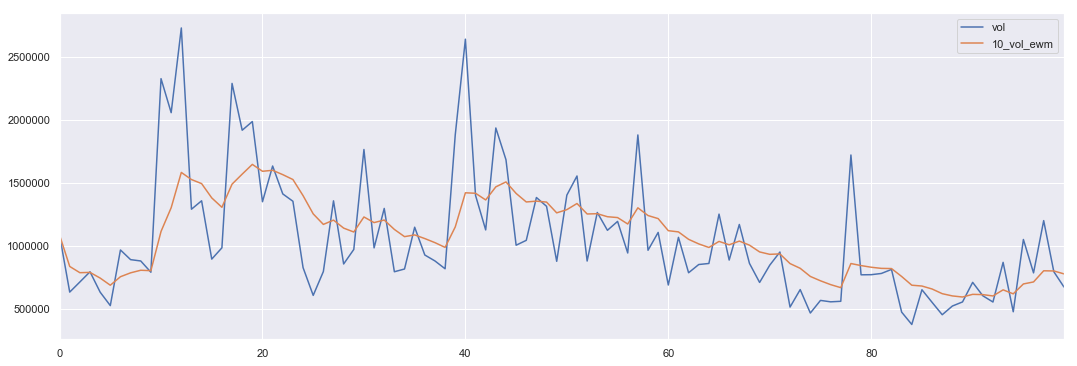

In [5]:
tickers['10_vol_ewm'] = tickers.groupby(['ts_code'])['vol'].apply(lambda x: vol_ewm(x, 10))
tickers[tickers['ts_code']=="000001.SZ"][['vol','10_vol_ewm']].plot(figsize = (18, 6))

In [6]:
# tickers_test['10_vol_ewm_rank'] = 
# df['normed_score'] = df.groupby(['ts'])[score_col].apply(lambda x: crrnt_norm_val_rank(x))
tickers['vol_rank'] = tickers.groupby(['trade_date'])['10_vol_ewm'].apply(lambda x: x.rank(ascending = False))

# today = str(datetime.now().date())
vol_rank_condition = tickers['vol_rank']<=100
filtered_df = tickers[(tickers['trade_date']==tickers['trade_date'].values[-1])&(vol_rank_condition)]
filtered_tickers = list(filtered_df['ts_code'].unique())

In [7]:
filtered_df.sort_values("vol_rank").head(20)

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount,10_vol_ewm,vol_rank
26899,000725.SZ,2019-12-19,4.69,4.81,4.62,4.69,4.66,0.03,0.6438,12833239.42,6055358.307,1.238818e+07,1.0
6099,000100.SZ,2019-12-19,4.43,4.52,4.38,4.43,4.44,-0.01,-0.2252,3756806.96,1666975.753,4.679064e+06,2.0
309605,601658.SH,2019-12-19,5.73,5.83,5.70,5.74,5.72,0.02,0.3497,1410280.76,811746.305,3.172500e+06,3.0
8399,000413.SZ,2019-12-19,3.66,3.75,3.57,3.63,3.69,-0.06,-1.6260,2757580.97,1001528.211,3.031479e+06,4.0
124003,002797.SZ,2019-12-19,8.30,8.30,8.05,8.20,8.51,-0.31,-3.6428,2856534.72,2339782.286,2.583493e+06,5.0
145214,300059.SZ,2019-12-19,15.63,15.72,15.36,15.49,15.63,-0.14,-0.8957,1996599.54,3097295.686,2.464069e+06,6.0
302297,601162.SH,2019-12-19,7.16,7.30,7.08,7.13,7.38,-0.25,-3.3875,2393392.67,1714785.939,2.375625e+06,7.0
148014,300088.SZ,2019-12-19,11.07,11.07,10.55,10.80,11.04,-0.24,-2.1739,2035200.67,2197224.894,2.279452e+06,8.0
58803,002131.SZ,2019-12-19,2.50,2.59,2.46,2.54,2.49,0.05,2.0080,3817376.38,962036.512,2.238087e+06,9.0
217359,600010.SH,2019-12-19,1.33,1.34,1.32,1.33,1.34,-0.01,-0.7463,1780482.21,236535.118,2.020414e+06,10.0


In [21]:
def MACD(df, n_fast, n_slow, n_macd): # n_fast = 12, n_slow = 26
    """
    http://stockcharts.com/docs/doku.php?id=scans:indicators
    """
    """
    MACD, MACD Signal and MACD difference, rationale CHECKED, code CHECKED, updated
    # Conventional look-back window for calculating MACDsign is 9
    """
    EMAfast = df['close'].ewm(span = n_fast, min_periods = n_fast - 1).mean()
    EMAslow = df['close'].ewm(span = n_slow, min_periods = n_slow - 1).mean()
    MACD = pd.Series(EMAfast - EMAslow, name = 'MACD_' + str(n_fast) + '_' + str(n_slow))
    MACDsign = MACD.ewm(span = n_macd, min_periods = n_macd-1).mean().rename('MACDsign_' + str(n_fast) + '_' + str(n_slow))
    MACDdiff = pd.Series(MACD - MACDsign, name = 'MACDdiff_' + str(n_fast) + '_' + str(n_slow))
    df['MACD_Diff'] = MACD
    df['MACD_Diff_EMA'] = MACDsign
    df['MACD'] = MACDdiff
    df['MACD_signal'] = df['MACD'].apply(lambda x: "多头信号" if x>0 else ("空头信号" if x<0 else "空仓信号"))
#     return MACD, MACDsign, MACDdiff
    return df

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

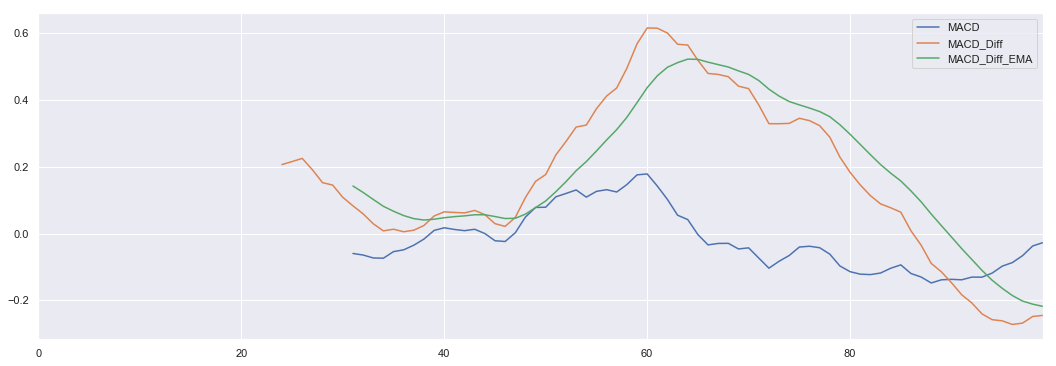

In [22]:
MACD(tickers[tickers['ts_code']=="000001.SZ"], 12, 26, 9)[['MACD','MACD_Diff','MACD_Diff_EMA']].plot(figsize = (18,6))

In [23]:
filtered_tickers

['000002.SZ',
 '000008.SZ',
 '000016.SZ',
 '000021.SZ',
 '000040.SZ',
 '000050.SZ',
 '000063.SZ',
 '000066.SZ',
 '000069.SZ',
 '000100.SZ',
 '000157.SZ',
 '000158.SZ',
 '000166.SZ',
 '000338.SZ',
 '000413.SZ',
 '000425.SZ',
 '000536.SZ',
 '000540.SZ',
 '000563.SZ',
 '000595.SZ',
 '000625.SZ',
 '000717.SZ',
 '000723.SZ',
 '000725.SZ',
 '000727.SZ',
 '000735.SZ',
 '000750.SZ',
 '000776.SZ',
 '000783.SZ',
 '000807.SZ',
 '000823.SZ',
 '000835.SZ',
 '000859.SZ',
 '000876.SZ',
 '000932.SZ',
 '000933.SZ',
 '000961.SZ',
 '002017.SZ',
 '002024.SZ',
 '002027.SZ',
 '002036.SZ',
 '002045.SZ',
 '002065.SZ',
 '002071.SZ',
 '002077.SZ',
 '002079.SZ',
 '002100.SZ',
 '002124.SZ',
 '002129.SZ',
 '002131.SZ',
 '002152.SZ',
 '002156.SZ',
 '002157.SZ',
 '002161.SZ',
 '002174.SZ',
 '002185.SZ',
 '002195.SZ',
 '002256.SZ',
 '002273.SZ',
 '002276.SZ',
 '002280.SZ',
 '002288.SZ',
 '002332.SZ',
 '002340.SZ',
 '002343.SZ',
 '002351.SZ',
 '002369.SZ',
 '002384.SZ',
 '002402.SZ',
 '002405.SZ',
 '002415.SZ',
 '0024

In [24]:
signal_record = []
for ticker in filtered_tickers:
    print("Calculating Signal for: ", ticker)
    try:
        single_ticker_df = tickers[tickers['ts_code']==ticker]
        signal_df = MACD(single_ticker_df, 12, 26, 9)
        last_signal = signal_df[['ts_code','MACD_signal']].values[-1]
        signal_record.append(last_signal)
    except:
        pass

Calculating Signal for:  000002.SZ
Calculating Signal for:  000008.SZ
Calculating Signal for:  000016.SZ
Calculating Signal for:  000021.SZ
Calculating Signal for:  000040.SZ
Calculating Signal for:  000050.SZ
Calculating Signal for:  000063.SZ
Calculating Signal for:  000066.SZ
Calculating Signal for:  000069.SZ
Calculating Signal for:  000100.SZ
Calculating Signal for:  000157.SZ
Calculating Signal for:  000158.SZ


/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

Calculating Signal for:  000166.SZ
Calculating Signal for:  000338.SZ
Calculating Signal for:  000413.SZ
Calculating Signal for:  000425.SZ
Calculating Signal for:  000536.SZ
Calculating Signal for:  000540.SZ
Calculating Signal for:  000563.SZ
Calculating Signal for:  000595.SZ
Calculating Signal for:  000625.SZ
Calculating Signal for:  000717.SZ
Calculating Signal for:  000723.SZ
Calculating Signal for:  000725.SZ
Calculating Signal for:  000727.SZ
Calculating Signal for:  000735.SZ
Calculating Signal for:  000750.SZ
Calculating Signal for:  000776.SZ
Calculating Signal for:  000783.SZ
Calculating Signal for:  000807.SZ
Calculating Signal for:  000823.SZ
Calculating Signal for:  000835.SZ
Calculating Signal for:  000859.SZ
Calculating Signal for:  000876.SZ
Calculating Signal for:  000932.SZ
Calculating Signal for:  000933.SZ
Calculating Signal for:  000961.SZ
Calculating Signal for:  002017.SZ
Calculating Signal for:  002024.SZ
Calculating Signal for:  002027.SZ
Calculating Signal f

In [25]:
signal_record

[array(['000002.SZ', '多头信号'], dtype=object),
 array(['000008.SZ', '多头信号'], dtype=object),
 array(['000016.SZ', '多头信号'], dtype=object),
 array(['000021.SZ', '多头信号'], dtype=object),
 array(['000040.SZ', '空头信号'], dtype=object),
 array(['000050.SZ', '多头信号'], dtype=object),
 array(['000063.SZ', '多头信号'], dtype=object),
 array(['000066.SZ', '多头信号'], dtype=object),
 array(['000069.SZ', '多头信号'], dtype=object),
 array(['000100.SZ', '多头信号'], dtype=object),
 array(['000157.SZ', '多头信号'], dtype=object),
 array(['000158.SZ', '多头信号'], dtype=object),
 array(['000166.SZ', '多头信号'], dtype=object),
 array(['000338.SZ', '多头信号'], dtype=object),
 array(['000413.SZ', '空头信号'], dtype=object),
 array(['000425.SZ', '多头信号'], dtype=object),
 array(['000536.SZ', '多头信号'], dtype=object),
 array(['000540.SZ', '多头信号'], dtype=object),
 array(['000563.SZ', '多头信号'], dtype=object),
 array(['000595.SZ', '多头信号'], dtype=object),
 array(['000625.SZ', '多头信号'], dtype=object),
 array(['000717.SZ', '多头信号'], dtype=object),
 array(['0

# 3. ETF数据

510050 - 华夏上证50ETF

ETF基金分为以下几类：

一、QDII基金：QD基金是指国内投资者对海外资本市场进行投资的一种基金。目前国内的QDII基金主要投资美股市场、港股市场，典型代表有华宝油气（162411）、标普500（513500）和香港中小（501021）等。

二、场内货币ETF：场内货币ETF指的是可以交易的货币基金。相比于普通的货币基金，此类基金在交易所上市，可以进行买卖和申赎。场内货币基金的买卖就和股票的操作一样，直接输入交易代码填写数量即可。场内货币ETF的典型代表有华宝添益（511990）、银华日利（511880）、建信添益（511660）等。

三、黄金ETF：黄金ETF指的是投资黄金的指数基金，跟踪的是现货黄金的价格波动。目前黄金ETF基金主要有四只，易方达黄金ETF(159934)、博时黄金159937、国泰黄金ETF（518800）、华安黄金ETF（518880）。

四、指数ETF：指数ETF是这四类ETF基金中数量最多、最常见的ETF金了。股民们熟悉的300ETF（510300）、创业板ETF（159915）、500ETF（510500）都是指数ETF基金。除了这些宽基指数基金外，还有跟踪行业指数的指数ETF，比如金融ETF(510230)、银行ETF（512800）、军工ETF（512660）、广发医药（159938）等。

# Chinese ETF

https://zhuanlan.zhihu.com/p/24920904

In [24]:
#抓取历史数据
today = str(datetime.now().date())

def GetHistoryData(Code, BeginTime, EndTime):
    df = ts.get_k_data(Code, index = False,  start = BeginTime, end = EndTime)
    return df

df_300_hist = GetHistoryData("510300", "2010-01-01", today)
df_nas_hist = GetHistoryData("513100", "2010-01-01", today)

In [28]:
df_300_hist.head(2)

,date,open,close,high,low,volume,code
0,2012-05-28,2.551,2.604,2.607,2.544,12775187.0,510300
1,2012-05-29,2.602,2.644,2.661,2.602,7149490.0,510300


In [2]:
import eventlet
eventlet.monkey_patch()

def GetHistoryData(Code, BeginTime, EndTime):
    df = ts.get_k_data(Code, index = False,  start = BeginTime, end = EndTime)
    return df

ch_db_path = "/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/CH_database/"

# ticker_list = codes
ch_etfs = pd.read_csv("/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/"+"CH_ETFs.csv")
ch_etfs['code'] =ch_etfs['证券代码'].apply(lambda x: str(x)[:6])
ch_etfs_ticker = list(ch_etfs['code'].unique())
partial_ticker_list = ['513500',#标普500
               '501021',#香港中小
               # 目前黄金ETF基金主要有四只，易方达黄金ETF(159934)、博时黄金159937、国泰黄金ETF（518800）、华安黄金ETF（518880）。
               '159934','159937','518800','518880',
               # 300ETF（510300）、创业板ETF（159915）、500ETF（510500）都是指数ETF基金。
               # 除了这些宽基指数基金外，还有跟踪行业指数的指数ETF，比如金融ETF(510230)、银行ETF（512800）、
               # 军工ETF（512660）、广发医药（159938）等。
               '510300','159915','510500','510230','512800','512660','159938']

ticker_list = list(set(ch_etfs_ticker+partial_ticker_list))
today = str(datetime.now().date())
start = '2010-01-01'
end = today
count = 1
for ticker in ticker_list:
    if count%200==0:
        print("=======================Sleeping======================")
        time.sleep(60)
    else:
        if not os.path.exists(ch_db_path+ticker+".csv"):
            print("ETF: {} is new, start downloading now...".format(ticker))
            try:
                data = GetHistoryData(ticker, "2010-01-01", today)
#                 print(data)
                data['date'] = data['date'].astype(str)
                data['date'] = data['date'].apply(lambda x:x[:4]+"-"+x[4:6]+"-"+x[6:] if len(x)!=10 else x)
                data.sort_values("date", inplace = True)
                data.to_csv(ch_db_path+ticker+".csv", index = False)
                print("ETF: {} data file created: {}".format(ticker, end))
            except Exception as e:
                print(e)

        else:
            print("ETF: Already have data csv for {}".format(ticker))
            hist_data = pd.read_csv(ch_db_path+ticker+".csv")   
            hist_data['date'] = hist_data['date'].astype(str)
            hist_data['date'] = hist_data['date'].apply(lambda x:x[:4]+"-"+x[4:6]+"-"+x[6:] if len(x)!=10 else x)
            hist_data.to_csv(ch_db_path+ticker+".csv", index = False)
            hist_data = pd.read_csv(ch_db_path+ticker+".csv")
            try:
                hist_data_last_date = hist_data['date'].values[-1]        
                if today > hist_data_last_date:
                    print("ETF: Needs to update, start updating new data for {} now...".format(ticker))
                    update_start = hist_data_last_date
                    update_end = today
                    with eventlet.Timeout(60,False):
                        try:
                            new_data = GetHistoryData(ticker, update_start, update_end)
                            new_data['date'] = new_data['date'].astype(str)
                            new_data['date'] = new_data['date'].apply(lambda x:x[:4]+"-"+x[4:6]+"-"+x[6:])
                            new_data.to_csv(ch_db_path+ticker+".csv", mode='a', header=False, index = False)
                            updated_duplicated_df = pd.read_csv(ch_db_path+ticker+".csv")
                            updated_df = updated_duplicated_df.drop_duplicates("date")
                            updated_df.sort_values("date", inplace = True)
                            updated_df.to_csv(ch_db_path+ticker+".csv", index = False)
                            print("ETF: New data updated till today for {}!".format(ticker))
                        except Exception as e:
                            print(e)
        #             print("Timed Out: Update Failed!")
                else:
                    print("ETF: There's no new data to update for {}.".format(ticker))
            except Exception as e:
                print(e)

    #     print("Data Download/Update for {} is Finished.".format(ticker))
        print("=======================Executed: {}=======================".format(count))
    count+=1
print("【ETF: Updated Finished for today!】")

ETF: 515360 is new, start downloading now...
ETF: 515360 data file created: 2019-12-21
=======================Executed: 1=======================
ETF: 511060 is new, start downloading now...
ETF: 511060 data file created: 2019-12-21
=======================Executed: 2=======================
ETF: 159971 is new, start downloading now...
ETF: 159971 data file created: 2019-12-21
=======================Executed: 3=======================
ETF: 159906 is new, start downloading now...
ETF: 159906 data file created: 2019-12-21
=======================Executed: 4=======================
ETF: 510350 is new, start downloading now...
ETF: 510350 data file created: 2019-12-21
=======================Executed: 5=======================
ETF: 510630 is new, start downloading now...
ETF: 510630 data file created: 2019-12-21
=======================Executed: 6=======================
ETF: 512200 is new, start downloading now...
ETF: 512200 data file created: 2019-12-21
=======================Executed: 7=========

ETF: 512870 data file created: 2019-12-21
=======================Executed: 59=======================
ETF: 510890 is new, start downloading now...
ETF: 510890 data file created: 2019-12-21
=======================Executed: 60=======================
ETF: 510380 is new, start downloading now...
ETF: 510380 data file created: 2019-12-21
=======================Executed: 61=======================
ETF: 513600 is new, start downloading now...
ETF: 513600 data file created: 2019-12-21
=======================Executed: 62=======================
ETF: 512910 is new, start downloading now...
ETF: 512910 data file created: 2019-12-21
=======================Executed: 63=======================
ETF: 515520 is new, start downloading now...
ETF: 515520 data file created: 2019-12-21
=======================Executed: 64=======================
ETF: 512270 is new, start downloading now...
ETF: 512270 data file created: 2019-12-21
=======================Executed: 65=======================
ETF: 159941 is new, sta

ETF: 515900 data file created: 2019-12-21
=======================Executed: 117=======================
ETF: 513100 is new, start downloading now...
ETF: 513100 data file created: 2019-12-21
=======================Executed: 118=======================
ETF: 511010 is new, start downloading now...
ETF: 511010 data file created: 2019-12-21
=======================Executed: 119=======================
ETF: 510600 is new, start downloading now...
ETF: 510600 data file created: 2019-12-21
=======================Executed: 120=======================
ETF: 510900 is new, start downloading now...
ETF: 510900 data file created: 2019-12-21
=======================Executed: 121=======================
ETF: 510680 is new, start downloading now...
ETF: 510680 data file created: 2019-12-21
=======================Executed: 122=======================
ETF: 512400 is new, start downloading now...
ETF: 512400 data file created: 2019-12-21
=======================Executed: 123=======================
ETF: 510550 is n

ETF: 512150 data file created: 2019-12-21
=======================Executed: 166=======================
ETF: 159949 is new, start downloading now...
ETF: 159949 data file created: 2019-12-21
=======================Executed: 167=======================
ETF: 513520 is new, start downloading now...
ETF: 513520 data file created: 2019-12-21
=======================Executed: 168=======================
ETF: 511030 is new, start downloading now...
ETF: 511030 data file created: 2019-12-21
=======================Executed: 169=======================
ETF: 159935 is new, start downloading now...
ETF: 159935 data file created: 2019-12-21
=======================Executed: 170=======================
ETF: 511280 is new, start downloading now...
ETF: 511280 data file created: 2019-12-21
=======================Executed: 171=======================
ETF: 159911 is new, start downloading now...
ETF: 159911 data file created: 2019-12-21
=======================Executed: 172=======================
ETF: 512560 is n

ETF: New data updated till today for 518800!
=======================Executed: 222=======================
ETF: 510430 is new, start downloading now...
ETF: 510430 data file created: 2019-12-21
=======================Executed: 223=======================
ETF: 510800 is new, start downloading now...
ETF: 510800 data file created: 2019-12-21
=======================Executed: 224=======================
ETF: 510580 is new, start downloading now...
ETF: 510580 data file created: 2019-12-21
=======================Executed: 225=======================
ETF: 159964 is new, start downloading now...
ETF: 159964 data file created: 2019-12-21
=======================Executed: 226=======================
ETF: 510660 is new, start downloading now...
ETF: 510660 data file created: 2019-12-21
=======================Executed: 227=======================
ETF: 512010 is new, start downloading now...
ETF: 512010 data file created: 2019-12-21
=======================Executed: 228=======================
ETF: 511020 i

In [3]:
ticker_list

['515360',
 '511060',
 '159971',
 '159906',
 '510350',
 '510630',
 '512200',
 'nan',
 '515880',
 '510300',
 '515703',
 '515353',
 '510710',
 '159938',
 '159909',
 '515983',
 '512990',
 '515110',
 '510060',
 '515060',
 '510530',
 '159975',
 '512880',
 '512290',
 '513800',
 '510120',
 '159923',
 '510050',
 '512580',
 '159905',
 '515680',
 '512070',
 '511310',
 '510090',
 '159968',
 '159960',
 '512510',
 '515163',
 '159961',
 '512180',
 '512390',
 '515800',
 '515180',
 '510190',
 '512160',
 '159954',
 '512280',
 '512190',
 '159972',
 '512520',
 '512850',
 '159980',
 '515990',
 '510590',
 '510220',
 '159932',
 '159957',
 '159943',
 '512870',
 '510890',
 '510380',
 '513600',
 '512910',
 '515520',
 '512270',
 '159941',
 '510440',
 '512000',
 '510510',
 '159969',
 '159903',
 '159982',
 '515010',
 '159987',
 '512760',
 '515150',
 '159976',
 '515093',
 '512600',
 '159970',
 '515580',
 '512890',
 '159901',
 '510100',
 '159929',
 '512170',
 '515810',
 '518880',
 '512710',
 '512040',
 '159958',
 '

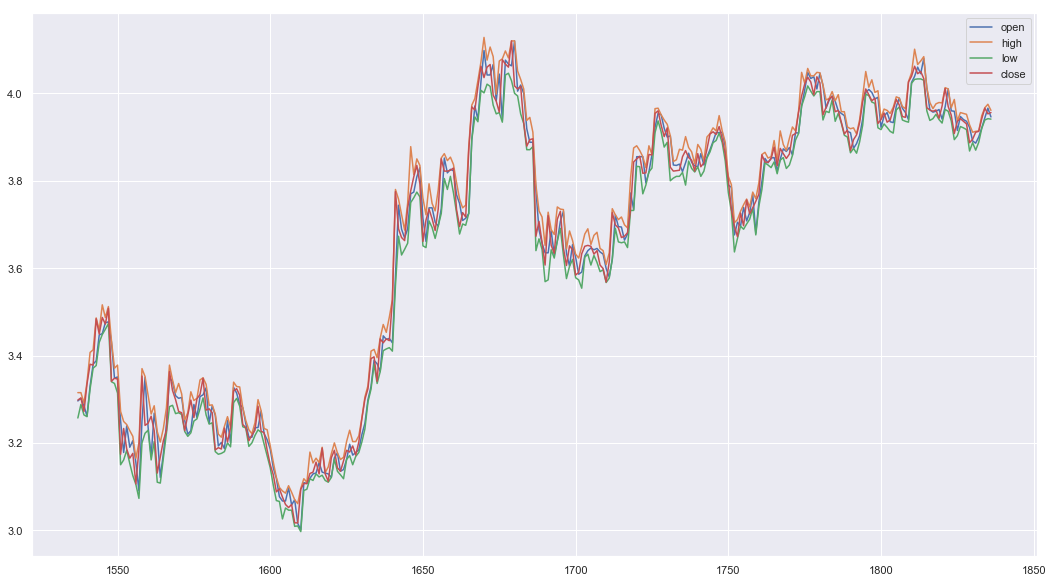

In [20]:
df_300_hist[['open','high','low','close']].tail(300).plot(figsize = (18,10))

https://zhuanlan.zhihu.com/p/24920904

# Plotly Application

https://www.jianshu.com/p/e5fb1b5c0957

In [8]:
from plotly.graph_objs import Scatter,Layout
import plotly
import plotly.offline as py
import numpy as np
import plotly.graph_objs as go

#setting offilne
plotly.offline.init_notebook_mode(connected=True)

In [18]:
import matplotlib.pyplot as plt

%matplotlib inline

In [22]:
N = 100
random_x = np.linspace(0,1,N)
random_y0 = np.random.randn(N)+5
random_y1 = np.random.randn(N)
random_y2 = np.random.randn(N)-5

#Create traces
trace0 = go.Scatter(
    x = random_x,
    y = random_y0,
    mode = 'markers',
    name = 'markers'
)
trace1 = go.Scatter(
    x = random_x,
    y = random_y1,
    mode = 'lines+markers',
    name = 'lines+markers'
)
trace2 = go.Scatter(
    x = random_x,
    y = random_y2,
    mode = 'lines',
    name = 'lines'
)
data = [trace0,trace1,trace2]
py.plot(data)

'temp-plot.html'

In [21]:
trace0 = go.Scatter(
    x=[1, 2, 3, 4],
    y=[10, 15, 13, 17]
)
trace1 = go.Scatter(
    x=[1, 2, 3, 4],
    y=[16, 5, 11, 9]
)
data = [trace0, trace1]

py.plot(data, filename = 'basic-line', auto_open=True)  #返回一个链接地址

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/plotly/offline/offline.py:526: UserWarning:

Your filename `basic-line` didn't end with .html. Adding .html to the end of your file.



'basic-line.html'

In [19]:

plt.show()

In [12]:
py.iplot(data)

In [13]:
trace1 = go.Scatter(
     y = np.random.randn(500),
    mode = 'markers',
    marker = dict(
        size = 16,
        color = np.random.randn(500),
        colorscale = 'Viridis',
        showscale = True
    )
)
data = [trace1]
py.iplot(data)